#                               Classification of Dog Breeds

Satyam Prasad Deva Sarmah

National Institute Of Technology Silchar

Computer Science And Engineering

Submitted to : VoltaML

# Introduction

Who's a good dog? Who likes ear scratches? Well, it seems those fancy deep neural networks don't have all the answers. 
However, maybe they can answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of 
good pup is that?

In this jupyter notebook I tried to provide a solution on how well people can differentiate your Norfolk Terriers from your
Norwich Terriers? With 120 breeds of dogs and a limited number training images per class.


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os,cv2,random,time,shutil,csv
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tqdm import tqdm
import json,os,cv2,keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import load_img

# Loading the dataset

In [2]:
train_dir='../Downloads/dog-breed-identification/train'
test_dir='../Downloads/dog-breed-identification/test'

In [3]:
labels_dataframe=pd.read_csv('../Downloads/dog-breed-identification/labels.csv')
sample_df=pd.read_csv('../Downloads/dog-breed-identification/sample_submission.csv')

In [4]:
labels_dataframe

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [5]:
labels_dataframe.shape

(10222, 2)

In [6]:
labels_dataframe.isnull().sum()

id       0
breed    0
dtype: int64

In [7]:
print("No of dog's images in train directory",len(os.listdir(train_dir)))
print("No of dog's images in test directory",len(os.listdir(test_dir)))

No of dog's images in train directory 10222
No of dog's images in test directory 10357


In [8]:
labels_dataframe['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [9]:
labels_dataframe['breed'].nunique()

120

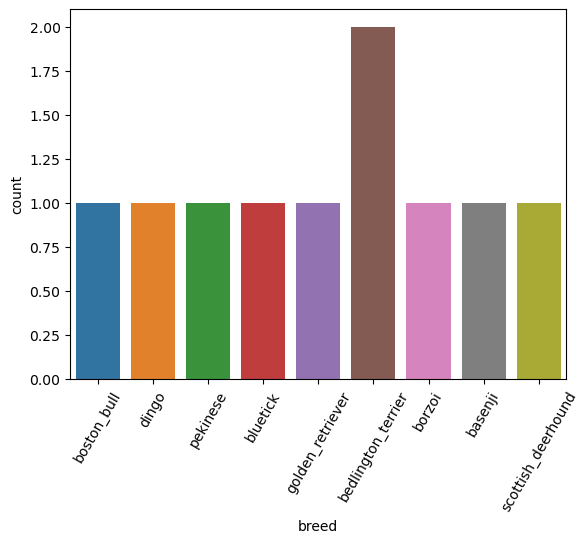

In [10]:
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
sns.countplot(labels_dataframe['breed'][:10])
plt.xticks(rotation=60)
plt.show()

In [11]:
dog_breeds=sorted(list(set(labels_dataframe['breed'])))
n_classes=len(dog_breeds)
print(n_classes)
print(dog_breeds[:15])

120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound']


In [12]:
classes_to_num=dict(zip(dog_breeds,range(n_classes)))

In [13]:
classes_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

# Preprocessing of Data

In [14]:
(train_dir+'/'+labels_dataframe['id']+'.jpg')[0]

'../Downloads/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [15]:
cv2.imread((train_dir+'/'+labels_dataframe['id']+'.jpg')[0]).shape

(375, 500, 3)

In [16]:
cv2.imread((train_dir+'/'+labels_dataframe['id']+'.jpg')[9]).shape

(332, 500, 3)

In [17]:
plt.imshow(cv2.imread((train_dir+'/'+labels_dataframe.id+'.jpg')[1]))

In [18]:
labels_dataframe['file_name']=labels_dataframe['id'].apply(lambda x: train_dir+'/'+f"{x}.jpg")
labels_dataframe

id                     breed  \
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull   
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo   
2      001cdf01b096e06d78e9e5112d419397                  pekinese   
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick   
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever   
...                                 ...                       ...   
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi   
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont   
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale   
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher   
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever   

                                               file_name  
0      ../Downloads/dog-breed-identification/train/00...  
1      ../Downloads/dog-breed-identification/train/00...  
2      ../Downloads/dog-breed-identification/train/00...  
3      ../Downloads/dog-breed-identification/train/00...  
4      ../Downloads/dog-breed-identification/train/00...  
...                                                  ...  
10217  ../Downloads/dog-breed-identification/train/ff...  
10218  ../Downloads/dog-breed-identification/train/ff...  
10219  ../Downloads/dog-breed-identification/train/ff...  
10220  ../Downloads/dog-breed-identification/train/ff...  
10221  ../Downloads/dog-breed-identification/train/ff...  

[10222 rows x 3 columns]

In [19]:
plt.imshow(cv2.imread(labels_dataframe['file_name'][8000]))

In [20]:
labels_dataframe['breed']=labels_dataframe['breed'].map(classes_to_num)
labels_dataframe

id  breed  \
0      000bec180eb18c7604dcecc8fe0dba07     19   
1      001513dfcb2ffafc82cccf4d8bbaba97     37   
2      001cdf01b096e06d78e9e5112d419397     85   
3      00214f311d5d2247d5dfe4fe24b2303d     15   
4      0021f9ceb3235effd7fcde7f7538ed62     49   
...                                 ...    ...   
10217  ffd25009d635cfd16e793503ac5edef0     18   
10218  ffd3f636f7f379c51ba3648a9ff8254f     35   
10219  ffe2ca6c940cddfee68fa3cc6c63213f      3   
10220  ffe5f6d8e2bff356e9482a80a6e29aac     75   
10221  fff43b07992508bc822f33d8ffd902ae     28   

                                               file_name  
0      ../Downloads/dog-breed-identification/train/00...  
1      ../Downloads/dog-breed-identification/train/00...  
2      ../Downloads/dog-breed-identification/train/00...  
3      ../Downloads/dog-breed-identification/train/00...  
4      ../Downloads/dog-breed-identification/train/00...  
...                                                  ...  
10217  ../Downloads/dog-breed-identification/train/ff...  
10218  ../Downloads/dog-breed-identification/train/ff...  
10219  ../Downloads/dog-breed-identification/train/ff...  
10220  ../Downloads/dog-breed-identification/train/ff...  
10221  ../Downloads/dog-breed-identification/train/ff...  

[10222 rows x 3 columns]

In [21]:
y=to_categorical(labels_dataframe['breed'])
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
y.shape

(10222, 120)

# Feature Extraction

In [23]:
import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input as resnet_preprocess
from keras.applications.inception_v3 import InceptionV3,preprocess_input as inception_preprocess
from keras.applications.xception import Xception , preprocess_input as xception_preprocess
from keras.applications.nasnet import NASNetLarge,preprocess_input as nasnet_preprocess
from tensorflow.keras.layers import concatenate

In [24]:
input_shape=(331,331,3)
input_layer=Input(shape=(input_shape))

In [25]:
input_layer

<KerasTensor: shape=(None, 331, 331, 3) dtype=float32 (created by layer 'input_1')>

In [26]:
%%time
preprocess_resnet=Lambda(resnet_preprocess)(input_layer)
inception_resnet=InceptionResNetV2(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocess_resnet)



preprocessor_inception=Lambda(inception_preprocess)(input_layer)
inception_v3=InceptionV3(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_inception)



preprocessor_xception=Lambda(xception_preprocess)(input_layer)
xception=Xception(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_xception)



preprocessor_nasnet=Lambda(nasnet_preprocess)(input_layer)
nasnet=NASNetLarge(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_nasnet)

CPU times: total: 26.7 s
Wall time: 18 s


In [27]:
preprocess_resnet

<KerasTensor: shape=(None, 331, 331, 3) dtype=float32 (created by layer 'lambda')>

In [28]:
inception_resnet

<KerasTensor: shape=(None, 1536) dtype=float32 (created by layer 'inception_resnet_v2')>

In [29]:
%%time
merge=concatenate([inception_resnet,inception_v3,xception,nasnet])
model=Model(inputs=input_layer,outputs=merge)

CPU times: total: 31.2 ms
Wall time: 7 ms


In [30]:
merge

<KerasTensor: shape=(None, 9664) dtype=float32 (created by layer 'concatenate_6')>

In [31]:
model

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 331, 331, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 331, 331, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 331, 331, 3)  0           ['input_1[0][0]']            

In [36]:
model.input.shape

TensorShape([None, 331, 331, 3])

In [37]:
model.output.shape

TensorShape([None, 9664])

In [38]:
len(model.trainable_weights)

1846

# Feature extraction by using pretrained model

In [39]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 22
    x = np.zeros([data_size,9664], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,x_col = 'file_name', class_mode = None, batch_size=batch_size, 
                                            shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    
    i = 0
    
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        x[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
            break
    return x
        

In [40]:
x=feature_extractor(labels_dataframe)

  0%|                                                                                          | 0/465 [00:00<?, ?it/s]

Found 10222 validated image filenames.
1/1 [==============================] - 17s 17s/step


  0%|▏                                                                               | 1/465 [00:16<2:08:58, 16.68s/it]

1/1 [==============================] - 8s 8s/step


  0%|▎                                                                               | 2/465 [00:24<1:49:17, 14.16s/it]

1/1 [==============================] - 8s 8s/step


  1%|▌                                                                               | 3/465 [00:33<1:35:36, 12.42s/it]

1/1 [==============================] - 8s 8s/step


  1%|▋                                                                               | 4/465 [00:41<1:25:45, 11.16s/it]

1/1 [==============================] - 8s 8s/step


  1%|▊                                                                               | 5/465 [00:49<1:19:01, 10.31s/it]

1/1 [==============================] - 8s 8s/step


  1%|█                                                                               | 6/465 [00:58<1:14:14,  9.71s/it]

1/1 [==============================] - 8s 8s/step


  2%|█▏                                                                              | 7/465 [01:06<1:10:55,  9.29s/it]

1/1 [==============================] - 8s 8s/step


  2%|█▍                                                                              | 8/465 [01:14<1:08:35,  9.01s/it]

1/1 [==============================] - 8s 8s/step


  2%|█▌                                                                              | 9/465 [01:23<1:06:54,  8.80s/it]

1/1 [==============================] - 8s 8s/step


  2%|█▋                                                                             | 10/465 [01:31<1:05:31,  8.64s/it]

1/1 [==============================] - 8s 8s/step


  2%|█▊                                                                             | 11/465 [01:39<1:04:41,  8.55s/it]

1/1 [==============================] - 8s 8s/step


  3%|██                                                                             | 12/465 [01:48<1:04:02,  8.48s/it]

1/1 [==============================] - 8s 8s/step


  3%|██▏                                                                            | 13/465 [01:56<1:03:28,  8.43s/it]

1/1 [==============================] - 8s 8s/step


  3%|██▍                                                                            | 14/465 [02:04<1:03:16,  8.42s/it]

1/1 [==============================] - 8s 8s/step


  3%|██▌                                                                            | 15/465 [02:13<1:02:59,  8.40s/it]

1/1 [==============================] - 8s 8s/step


  3%|██▋                                                                            | 16/465 [02:21<1:02:31,  8.36s/it]

1/1 [==============================] - 8s 8s/step


  4%|██▉                                                                            | 17/465 [02:29<1:02:47,  8.41s/it]

1/1 [==============================] - 8s 8s/step


  4%|███                                                                            | 18/465 [02:38<1:02:19,  8.37s/it]

1/1 [==============================] - 8s 8s/step


  4%|███▏                                                                           | 19/465 [02:46<1:02:21,  8.39s/it]

1/1 [==============================] - 8s 8s/step


  4%|███▍                                                                           | 20/465 [02:55<1:02:24,  8.41s/it]

1/1 [==============================] - 8s 8s/step


  5%|███▌                                                                           | 21/465 [03:03<1:02:03,  8.39s/it]

1/1 [==============================] - 8s 8s/step


  5%|███▋                                                                           | 22/465 [03:11<1:02:02,  8.40s/it]

1/1 [==============================] - 8s 8s/step


  5%|███▉                                                                           | 23/465 [03:20<1:01:50,  8.40s/it]

1/1 [==============================] - 8s 8s/step


  5%|████                                                                           | 24/465 [03:28<1:01:35,  8.38s/it]

1/1 [==============================] - 8s 8s/step


  5%|████▏                                                                          | 25/465 [03:36<1:01:22,  8.37s/it]

1/1 [==============================] - 8s 8s/step


  6%|████▍                                                                          | 26/465 [03:45<1:01:10,  8.36s/it]

1/1 [==============================] - 8s 8s/step


  6%|████▌                                                                          | 27/465 [03:53<1:00:50,  8.33s/it]

1/1 [==============================] - 8s 8s/step


  6%|████▊                                                                          | 28/465 [04:01<1:00:51,  8.35s/it]

1/1 [==============================] - 8s 8s/step


  6%|████▉                                                                          | 29/465 [04:10<1:00:36,  8.34s/it]

1/1 [==============================] - 8s 8s/step


  6%|█████                                                                          | 30/465 [04:18<1:00:27,  8.34s/it]

1/1 [==============================] - 8s 8s/step


  7%|█████▎                                                                         | 31/465 [04:26<1:00:23,  8.35s/it]

1/1 [==============================] - 8s 8s/step


  7%|█████▍                                                                         | 32/465 [04:35<1:00:20,  8.36s/it]

1/1 [==============================] - 8s 8s/step


  7%|█████▌                                                                         | 33/465 [04:43<1:00:09,  8.36s/it]

1/1 [==============================] - 9s 9s/step


  7%|█████▊                                                                         | 34/465 [04:52<1:00:47,  8.46s/it]

1/1 [==============================] - 8s 8s/step


  8%|█████▉                                                                         | 35/465 [05:00<1:00:34,  8.45s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████                                                                         | 36/465 [05:09<1:00:08,  8.41s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████▍                                                                          | 37/465 [05:17<59:49,  8.39s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████▌                                                                          | 38/465 [05:25<59:39,  8.38s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████▊                                                                          | 39/465 [05:34<59:25,  8.37s/it]

1/1 [==============================] - 8s 8s/step


  9%|██████▉                                                                          | 40/465 [05:42<59:13,  8.36s/it]

1/1 [==============================] - 8s 8s/step


  9%|███████▏                                                                         | 41/465 [05:50<58:55,  8.34s/it]

1/1 [==============================] - 8s 8s/step


  9%|███████▎                                                                         | 42/465 [05:59<58:59,  8.37s/it]

1/1 [==============================] - 8s 8s/step


  9%|███████▍                                                                         | 43/465 [06:07<58:53,  8.37s/it]

1/1 [==============================] - 8s 8s/step


  9%|███████▋                                                                         | 44/465 [06:16<58:44,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 10%|███████▊                                                                         | 45/465 [06:24<58:40,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 10%|████████                                                                         | 46/465 [06:32<58:32,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 10%|████████▏                                                                        | 47/465 [06:41<58:20,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 10%|████████▎                                                                        | 48/465 [06:49<58:08,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 11%|████████▌                                                                        | 49/465 [06:57<57:57,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 11%|████████▋                                                                        | 50/465 [07:06<57:51,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 11%|████████▉                                                                        | 51/465 [07:14<57:55,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 11%|█████████                                                                        | 52/465 [07:23<58:11,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 11%|█████████▏                                                                       | 53/465 [07:31<57:54,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 12%|█████████▍                                                                       | 54/465 [07:40<57:43,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 12%|█████████▌                                                                       | 55/465 [07:48<57:36,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 12%|█████████▊                                                                       | 56/465 [07:56<57:13,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 12%|█████████▉                                                                       | 57/465 [08:05<56:59,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 12%|██████████                                                                       | 58/465 [08:13<56:52,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▎                                                                      | 59/465 [08:21<56:33,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▍                                                                      | 60/465 [08:30<56:24,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▋                                                                      | 61/465 [08:38<56:23,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▊                                                                      | 62/465 [08:46<56:12,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 14%|██████████▉                                                                      | 63/465 [08:55<56:07,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████▏                                                                     | 64/465 [09:03<56:16,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████▎                                                                     | 65/465 [09:12<56:22,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████▍                                                                     | 66/465 [09:21<56:35,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████▋                                                                     | 67/465 [09:29<56:23,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 15%|███████████▊                                                                     | 68/465 [09:37<55:52,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 15%|████████████                                                                     | 69/465 [09:46<55:30,  8.41s/it]

1/1 [==============================] - 8s 8s/step


 15%|████████████▏                                                                    | 70/465 [09:54<55:13,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 15%|████████████▎                                                                    | 71/465 [10:02<54:56,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 15%|████████████▌                                                                    | 72/465 [10:11<54:59,  8.40s/it]

1/1 [==============================] - 9s 9s/step


 16%|████████████▋                                                                    | 73/465 [10:20<55:39,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 16%|████████████▉                                                                    | 74/465 [10:28<55:22,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 16%|█████████████                                                                    | 75/465 [10:37<55:09,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 16%|█████████████▏                                                                   | 76/465 [10:45<54:49,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 17%|█████████████▍                                                                   | 77/465 [10:53<54:29,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 17%|█████████████▌                                                                   | 78/465 [11:02<54:11,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 17%|█████████████▊                                                                   | 79/465 [11:10<53:56,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 17%|█████████████▉                                                                   | 80/465 [11:18<53:35,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 17%|██████████████                                                                   | 81/465 [11:27<53:27,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▎                                                                  | 82/465 [11:35<53:25,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▍                                                                  | 83/465 [11:43<53:13,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▋                                                                  | 84/465 [11:52<53:08,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▊                                                                  | 85/465 [12:00<53:02,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▉                                                                  | 86/465 [12:09<52:59,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 19%|███████████████▏                                                                 | 87/465 [12:17<52:51,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 19%|███████████████▎                                                                 | 88/465 [12:25<52:32,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 19%|███████████████▌                                                                 | 89/465 [12:34<52:27,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 19%|███████████████▋                                                                 | 90/465 [12:42<52:19,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 20%|███████████████▊                                                                 | 91/465 [12:50<52:05,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 20%|████████████████                                                                 | 92/465 [12:59<52:05,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 20%|████████████████▏                                                                | 93/465 [13:07<51:58,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 20%|████████████████▎                                                                | 94/465 [13:15<51:42,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 20%|████████████████▌                                                                | 95/465 [13:24<51:42,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 21%|████████████████▋                                                                | 96/465 [13:32<51:37,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 21%|████████████████▉                                                                | 97/465 [13:41<51:25,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 21%|█████████████████                                                                | 98/465 [13:49<51:22,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 21%|█████████████████▏                                                               | 99/465 [13:57<51:01,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 22%|█████████████████▏                                                              | 100/465 [14:06<50:53,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 22%|█████████████████▍                                                              | 101/465 [14:14<50:45,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 22%|█████████████████▌                                                              | 102/465 [14:23<50:50,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 22%|█████████████████▋                                                              | 103/465 [14:31<50:41,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 22%|█████████████████▉                                                              | 104/465 [14:40<50:45,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████                                                              | 105/465 [14:48<50:25,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████▏                                                             | 106/465 [14:56<50:12,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████▍                                                             | 107/465 [15:05<49:56,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████▌                                                             | 108/465 [15:13<49:40,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████▊                                                             | 109/465 [15:21<49:22,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 24%|██████████████████▉                                                             | 110/465 [15:29<49:19,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 24%|███████████████████                                                             | 111/465 [15:38<49:06,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 24%|███████████████████▎                                                            | 112/465 [15:46<48:59,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 24%|███████████████████▍                                                            | 113/465 [15:55<49:02,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 25%|███████████████████▌                                                            | 114/465 [16:03<48:51,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 25%|███████████████████▊                                                            | 115/465 [16:11<48:48,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 25%|███████████████████▉                                                            | 116/465 [16:20<48:37,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 25%|████████████████████▏                                                           | 117/465 [16:28<48:27,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 25%|████████████████████▎                                                           | 118/465 [16:36<48:25,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 26%|████████████████████▍                                                           | 119/465 [16:45<48:06,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 26%|████████████████████▋                                                           | 120/465 [16:53<47:53,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 26%|████████████████████▊                                                           | 121/465 [17:01<47:52,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 26%|████████████████████▉                                                           | 122/465 [17:10<47:45,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 26%|█████████████████████▏                                                          | 123/465 [17:18<47:38,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 27%|█████████████████████▎                                                          | 124/465 [17:26<47:30,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 27%|█████████████████████▌                                                          | 125/465 [17:35<47:18,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 27%|█████████████████████▋                                                          | 126/465 [17:43<47:12,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 27%|█████████████████████▊                                                          | 127/465 [17:52<47:06,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 28%|██████████████████████                                                          | 128/465 [18:00<46:53,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 28%|██████████████████████▏                                                         | 129/465 [18:08<46:51,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 28%|██████████████████████▎                                                         | 130/465 [18:17<46:41,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 28%|██████████████████████▌                                                         | 131/465 [18:25<46:41,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 28%|██████████████████████▋                                                         | 132/465 [18:33<46:32,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 29%|██████████████████████▉                                                         | 133/465 [18:42<46:20,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 29%|███████████████████████                                                         | 134/465 [18:50<46:05,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 29%|███████████████████████▏                                                        | 135/465 [18:59<46:04,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 29%|███████████████████████▍                                                        | 136/465 [19:07<45:57,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 29%|███████████████████████▌                                                        | 137/465 [19:15<45:42,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 30%|███████████████████████▋                                                        | 138/465 [19:24<45:32,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 30%|███████████████████████▉                                                        | 139/465 [19:32<45:25,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 30%|████████████████████████                                                        | 140/465 [19:40<45:15,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 30%|████████████████████████▎                                                       | 141/465 [19:49<45:00,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 31%|████████████████████████▍                                                       | 142/465 [19:57<44:52,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 31%|████████████████████████▌                                                       | 143/465 [20:05<44:42,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 31%|████████████████████████▊                                                       | 144/465 [20:14<44:40,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 31%|████████████████████████▉                                                       | 145/465 [20:22<44:47,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 31%|█████████████████████████                                                       | 146/465 [20:30<44:36,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▎                                                      | 147/465 [20:39<44:29,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▍                                                      | 148/465 [20:47<44:22,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▋                                                      | 149/465 [20:56<44:07,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▊                                                      | 150/465 [21:04<43:50,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▉                                                      | 151/465 [21:12<43:41,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 33%|██████████████████████████▏                                                     | 152/465 [21:21<43:34,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 33%|██████████████████████████▎                                                     | 153/465 [21:29<43:22,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 33%|██████████████████████████▍                                                     | 154/465 [21:37<43:14,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 33%|██████████████████████████▋                                                     | 155/465 [21:46<43:07,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 34%|██████████████████████████▊                                                     | 156/465 [21:54<42:54,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 34%|███████████████████████████                                                     | 157/465 [22:02<42:48,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 34%|███████████████████████████▏                                                    | 158/465 [22:11<42:40,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 34%|███████████████████████████▎                                                    | 159/465 [22:19<42:23,  8.31s/it]

1/1 [==============================] - 9s 9s/step


 34%|███████████████████████████▌                                                    | 160/465 [22:28<43:02,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 35%|███████████████████████████▋                                                    | 161/465 [22:36<42:42,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 35%|███████████████████████████▊                                                    | 162/465 [22:44<42:25,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 35%|████████████████████████████                                                    | 163/465 [22:53<42:11,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 35%|████████████████████████████▏                                                   | 164/465 [23:01<42:03,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 35%|████████████████████████████▍                                                   | 165/465 [23:09<41:47,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 36%|████████████████████████████▌                                                   | 166/465 [23:18<41:38,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 36%|████████████████████████████▋                                                   | 167/465 [23:26<41:23,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 36%|████████████████████████████▉                                                   | 168/465 [23:34<41:12,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 36%|█████████████████████████████                                                   | 169/465 [23:43<41:05,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▏                                                  | 170/465 [23:51<40:57,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▍                                                  | 171/465 [23:59<40:42,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▌                                                  | 172/465 [24:08<40:34,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▊                                                  | 173/465 [24:16<40:27,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▉                                                  | 174/465 [24:24<40:25,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████                                                  | 175/465 [24:33<40:18,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████▎                                                 | 176/465 [24:41<40:12,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████▍                                                 | 177/465 [24:49<39:59,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████▌                                                 | 178/465 [24:58<39:47,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████▊                                                 | 179/465 [25:06<39:41,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 39%|██████████████████████████████▉                                                 | 180/465 [25:14<39:32,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 39%|███████████████████████████████▏                                                | 181/465 [25:23<39:20,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 39%|███████████████████████████████▎                                                | 182/465 [25:31<39:17,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 39%|███████████████████████████████▍                                                | 183/465 [25:39<39:08,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 40%|███████████████████████████████▋                                                | 184/465 [25:48<38:59,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 40%|███████████████████████████████▊                                                | 185/465 [25:56<38:54,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 40%|████████████████████████████████                                                | 186/465 [26:04<38:47,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 40%|████████████████████████████████▏                                               | 187/465 [26:13<38:38,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 40%|████████████████████████████████▎                                               | 188/465 [26:21<38:31,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 41%|████████████████████████████████▌                                               | 189/465 [26:29<38:27,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 41%|████████████████████████████████▋                                               | 190/465 [26:38<38:20,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 41%|████████████████████████████████▊                                               | 191/465 [26:46<38:10,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 41%|█████████████████████████████████                                               | 192/465 [26:54<37:57,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▏                                              | 193/465 [27:03<37:47,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▍                                              | 194/465 [27:11<37:30,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▌                                              | 195/465 [27:19<37:24,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▋                                              | 196/465 [27:28<37:17,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▉                                              | 197/465 [27:36<37:02,  8.29s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████                                              | 198/465 [27:44<36:57,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████▏                                             | 199/465 [27:53<36:50,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████▍                                             | 200/465 [28:01<36:45,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████▌                                             | 201/465 [28:09<36:37,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████▊                                             | 202/465 [28:18<36:29,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 44%|██████████████████████████████████▉                                             | 203/465 [28:26<36:22,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 44%|███████████████████████████████████                                             | 204/465 [28:34<36:19,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 44%|███████████████████████████████████▎                                            | 205/465 [28:43<36:15,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 44%|███████████████████████████████████▍                                            | 206/465 [28:51<36:00,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 45%|███████████████████████████████████▌                                            | 207/465 [28:59<35:50,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 45%|███████████████████████████████████▊                                            | 208/465 [29:08<35:41,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 45%|███████████████████████████████████▉                                            | 209/465 [29:16<35:34,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 45%|████████████████████████████████████▏                                           | 210/465 [29:24<35:24,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 45%|████████████████████████████████████▎                                           | 211/465 [29:33<35:15,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 46%|████████████████████████████████████▍                                           | 212/465 [29:41<35:06,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 46%|████████████████████████████████████▋                                           | 213/465 [29:49<34:59,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 46%|████████████████████████████████████▊                                           | 214/465 [29:58<34:48,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 46%|████████████████████████████████████▉                                           | 215/465 [30:06<34:45,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 46%|█████████████████████████████████████▏                                          | 216/465 [30:14<34:33,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 47%|█████████████████████████████████████▎                                          | 217/465 [30:23<34:24,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 47%|█████████████████████████████████████▌                                          | 218/465 [30:31<34:17,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 47%|█████████████████████████████████████▋                                          | 219/465 [30:39<34:05,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 47%|█████████████████████████████████████▊                                          | 220/465 [30:48<34:02,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████                                          | 221/465 [30:56<33:53,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████▏                                         | 222/465 [31:04<33:45,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████▎                                         | 223/465 [31:12<33:30,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████▌                                         | 224/465 [31:21<33:23,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████▋                                         | 225/465 [31:29<33:18,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 49%|██████████████████████████████████████▉                                         | 226/465 [31:37<33:06,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 49%|███████████████████████████████████████                                         | 227/465 [31:46<33:03,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 49%|███████████████████████████████████████▏                                        | 228/465 [31:54<32:54,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 49%|███████████████████████████████████████▍                                        | 229/465 [32:02<32:41,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 49%|███████████████████████████████████████▌                                        | 230/465 [32:11<32:38,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 50%|███████████████████████████████████████▋                                        | 231/465 [32:19<32:26,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 50%|███████████████████████████████████████▉                                        | 232/465 [32:27<32:17,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 50%|████████████████████████████████████████                                        | 233/465 [32:36<32:09,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 50%|████████████████████████████████████████▎                                       | 234/465 [32:44<32:02,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 51%|████████████████████████████████████████▍                                       | 235/465 [32:52<31:50,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 51%|████████████████████████████████████████▌                                       | 236/465 [33:01<31:51,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 51%|████████████████████████████████████████▊                                       | 237/465 [33:09<31:40,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 51%|████████████████████████████████████████▉                                       | 238/465 [33:17<31:34,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 51%|█████████████████████████████████████████                                       | 239/465 [33:26<31:24,  8.34s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▎                                      | 240/465 [33:34<31:19,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▍                                      | 241/465 [33:42<31:06,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▋                                      | 242/465 [33:51<30:55,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▊                                      | 243/465 [33:59<30:47,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▉                                      | 244/465 [34:07<30:38,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 53%|██████████████████████████████████████████▏                                     | 245/465 [34:16<30:26,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 53%|██████████████████████████████████████████▎                                     | 246/465 [34:24<30:19,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 53%|██████████████████████████████████████████▍                                     | 247/465 [34:32<30:21,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 53%|██████████████████████████████████████████▋                                     | 248/465 [34:41<30:04,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 54%|██████████████████████████████████████████▊                                     | 249/465 [34:49<29:57,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 54%|███████████████████████████████████████████                                     | 250/465 [34:57<29:49,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 54%|███████████████████████████████████████████▏                                    | 251/465 [35:06<29:34,  8.29s/it]

1/1 [==============================] - 8s 8s/step


 54%|███████████████████████████████████████████▎                                    | 252/465 [35:14<29:29,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 54%|███████████████████████████████████████████▌                                    | 253/465 [35:22<29:24,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 55%|███████████████████████████████████████████▋                                    | 254/465 [35:30<29:12,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 55%|███████████████████████████████████████████▊                                    | 255/465 [35:39<29:04,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 55%|████████████████████████████████████████████                                    | 256/465 [35:47<28:57,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 55%|████████████████████████████████████████████▏                                   | 257/465 [35:55<28:49,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 55%|████████████████████████████████████████████▍                                   | 258/465 [36:04<28:39,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 56%|████████████████████████████████████████████▌                                   | 259/465 [36:12<28:30,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 56%|████████████████████████████████████████████▋                                   | 260/465 [36:20<28:21,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 56%|████████████████████████████████████████████▉                                   | 261/465 [36:29<28:15,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 56%|█████████████████████████████████████████████                                   | 262/465 [36:37<28:09,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▏                                  | 263/465 [36:45<28:00,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▍                                  | 264/465 [36:54<27:47,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▌                                  | 265/465 [37:02<27:40,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▊                                  | 266/465 [37:10<27:36,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▉                                  | 267/465 [37:19<27:24,  8.31s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████                                  | 268/465 [37:27<27:20,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████▎                                 | 269/465 [37:36<27:30,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████▍                                 | 270/465 [37:44<27:13,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████▌                                 | 271/465 [37:52<27:00,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████▊                                 | 272/465 [38:01<26:59,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 59%|██████████████████████████████████████████████▉                                 | 273/465 [38:09<26:46,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 59%|███████████████████████████████████████████████▏                                | 274/465 [38:17<26:49,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 59%|███████████████████████████████████████████████▎                                | 275/465 [38:26<26:35,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 59%|███████████████████████████████████████████████▍                                | 276/465 [38:34<26:30,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 60%|███████████████████████████████████████████████▋                                | 277/465 [38:43<26:22,  8.42s/it]

1/1 [==============================] - 9s 9s/step


 60%|███████████████████████████████████████████████▊                                | 278/465 [38:52<26:58,  8.66s/it]

1/1 [==============================] - 9s 9s/step


 60%|████████████████████████████████████████████████                                | 279/465 [39:01<27:12,  8.78s/it]

1/1 [==============================] - 9s 9s/step


 60%|████████████████████████████████████████████████▏                               | 280/465 [39:10<26:59,  8.75s/it]

1/1 [==============================] - 9s 9s/step


 60%|████████████████████████████████████████████████▎                               | 281/465 [39:18<26:52,  8.76s/it]

1/1 [==============================] - 9s 9s/step


 61%|████████████████████████████████████████████████▌                               | 282/465 [39:27<26:37,  8.73s/it]

1/1 [==============================] - 8s 8s/step


 61%|████████████████████████████████████████████████▋                               | 283/465 [39:36<26:16,  8.66s/it]

1/1 [==============================] - 8s 8s/step


 61%|████████████████████████████████████████████████▊                               | 284/465 [39:44<26:02,  8.63s/it]

1/1 [==============================] - 8s 8s/step


 61%|█████████████████████████████████████████████████                               | 285/465 [39:53<25:39,  8.55s/it]

1/1 [==============================] - 8s 8s/step


 62%|█████████████████████████████████████████████████▏                              | 286/465 [40:01<25:27,  8.53s/it]

1/1 [==============================] - 8s 8s/step


 62%|█████████████████████████████████████████████████▍                              | 287/465 [40:10<25:17,  8.53s/it]

1/1 [==============================] - 9s 9s/step


 62%|█████████████████████████████████████████████████▌                              | 288/465 [40:18<25:21,  8.60s/it]

1/1 [==============================] - 9s 9s/step


 62%|█████████████████████████████████████████████████▋                              | 289/465 [40:27<25:15,  8.61s/it]

1/1 [==============================] - 9s 9s/step


 62%|█████████████████████████████████████████████████▉                              | 290/465 [40:36<25:09,  8.63s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████                              | 291/465 [40:44<24:46,  8.54s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████▏                             | 292/465 [40:52<24:36,  8.53s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████▍                             | 293/465 [41:01<24:12,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████▌                             | 294/465 [41:09<24:06,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████▊                             | 295/465 [41:17<23:40,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 64%|██████████████████████████████████████████████████▉                             | 296/465 [41:25<23:16,  8.26s/it]

1/1 [==============================] - 8s 8s/step


 64%|███████████████████████████████████████████████████                             | 297/465 [41:33<23:01,  8.22s/it]

1/1 [==============================] - 8s 8s/step


 64%|███████████████████████████████████████████████████▎                            | 298/465 [41:42<22:47,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 64%|███████████████████████████████████████████████████▍                            | 299/465 [41:50<22:51,  8.27s/it]

1/1 [==============================] - 8s 8s/step


 65%|███████████████████████████████████████████████████▌                            | 300/465 [41:58<22:46,  8.28s/it]

1/1 [==============================] - 8s 8s/step


 65%|███████████████████████████████████████████████████▊                            | 301/465 [42:07<22:46,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 65%|███████████████████████████████████████████████████▉                            | 302/465 [42:15<22:24,  8.25s/it]

1/1 [==============================] - 8s 8s/step


 65%|████████████████████████████████████████████████████▏                           | 303/465 [42:23<22:24,  8.30s/it]

1/1 [==============================] - 9s 9s/step


 65%|████████████████████████████████████████████████████▎                           | 304/465 [42:32<22:35,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 66%|████████████████████████████████████████████████████▍                           | 305/465 [42:40<22:34,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 66%|████████████████████████████████████████████████████▋                           | 306/465 [42:49<22:33,  8.51s/it]

1/1 [==============================] - 9s 9s/step


 66%|████████████████████████████████████████████████████▊                           | 307/465 [42:58<22:34,  8.57s/it]

1/1 [==============================] - 9s 9s/step


 66%|████████████████████████████████████████████████████▉                           | 308/465 [43:06<22:29,  8.60s/it]

1/1 [==============================] - 9s 9s/step


 66%|█████████████████████████████████████████████████████▏                          | 309/465 [43:15<22:24,  8.62s/it]

1/1 [==============================] - 8s 8s/step


 67%|█████████████████████████████████████████████████████▎                          | 310/465 [43:24<22:06,  8.56s/it]

1/1 [==============================] - 9s 9s/step


 67%|█████████████████████████████████████████████████████▌                          | 311/465 [43:32<22:02,  8.59s/it]

1/1 [==============================] - 8s 8s/step


 67%|█████████████████████████████████████████████████████▋                          | 312/465 [43:41<21:49,  8.56s/it]

1/1 [==============================] - 8s 8s/step


 67%|█████████████████████████████████████████████████████▊                          | 313/465 [43:49<21:32,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████                          | 314/465 [43:58<21:23,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████▏                         | 315/465 [44:06<21:10,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████▎                         | 316/465 [44:14<20:56,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████▌                         | 317/465 [44:23<20:45,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████▋                         | 318/465 [44:31<20:36,  8.41s/it]

1/1 [==============================] - 8s 8s/step


 69%|██████████████████████████████████████████████████████▉                         | 319/465 [44:40<20:28,  8.41s/it]

1/1 [==============================] - 8s 8s/step


 69%|███████████████████████████████████████████████████████                         | 320/465 [44:48<20:14,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 69%|███████████████████████████████████████████████████████▏                        | 321/465 [44:56<20:05,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 69%|███████████████████████████████████████████████████████▍                        | 322/465 [45:05<19:59,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 69%|███████████████████████████████████████████████████████▌                        | 323/465 [45:13<19:52,  8.40s/it]

1/1 [==============================] - 8s 8s/step


 70%|███████████████████████████████████████████████████████▋                        | 324/465 [45:21<19:40,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 70%|███████████████████████████████████████████████████████▉                        | 325/465 [45:30<19:30,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 70%|████████████████████████████████████████████████████████                        | 326/465 [45:38<19:25,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 70%|████████████████████████████████████████████████████████▎                       | 327/465 [45:47<19:21,  8.41s/it]

1/1 [==============================] - 9s 9s/step


 71%|████████████████████████████████████████████████████████▍                       | 328/465 [45:55<19:26,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 71%|████████████████████████████████████████████████████████▌                       | 329/465 [46:04<19:17,  8.51s/it]

1/1 [==============================] - 9s 9s/step


 71%|████████████████████████████████████████████████████████▊                       | 330/465 [46:12<19:12,  8.54s/it]

1/1 [==============================] - 8s 8s/step


 71%|████████████████████████████████████████████████████████▉                       | 331/465 [46:21<18:54,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 71%|█████████████████████████████████████████████████████████                       | 332/465 [46:29<18:35,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▎                      | 333/465 [46:37<18:24,  8.37s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▍                      | 334/465 [46:45<18:05,  8.29s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▋                      | 335/465 [46:54<17:57,  8.29s/it]

1/1 [==============================] - 9s 9s/step


 72%|█████████████████████████████████████████████████████████▊                      | 336/465 [47:02<18:06,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▉                      | 337/465 [47:11<17:48,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 73%|██████████████████████████████████████████████████████████▏                     | 338/465 [47:19<17:34,  8.31s/it]

1/1 [==============================] - 9s 9s/step


 73%|██████████████████████████████████████████████████████████▎                     | 339/465 [47:28<17:45,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 73%|██████████████████████████████████████████████████████████▍                     | 340/465 [47:36<17:27,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 73%|██████████████████████████████████████████████████████████▋                     | 341/465 [47:44<17:13,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 74%|██████████████████████████████████████████████████████████▊                     | 342/465 [47:52<16:56,  8.26s/it]

1/1 [==============================] - 8s 8s/step


 74%|███████████████████████████████████████████████████████████                     | 343/465 [48:00<16:50,  8.28s/it]

1/1 [==============================] - 8s 8s/step


 74%|███████████████████████████████████████████████████████████▏                    | 344/465 [48:09<16:39,  8.26s/it]

1/1 [==============================] - 8s 8s/step


 74%|███████████████████████████████████████████████████████████▎                    | 345/465 [48:17<16:30,  8.25s/it]

1/1 [==============================] - 8s 8s/step


 74%|███████████████████████████████████████████████████████████▌                    | 346/465 [48:25<16:17,  8.22s/it]

1/1 [==============================] - 8s 8s/step


 75%|███████████████████████████████████████████████████████████▋                    | 347/465 [48:33<16:05,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 75%|███████████████████████████████████████████████████████████▊                    | 348/465 [48:41<15:55,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 75%|████████████████████████████████████████████████████████████                    | 349/465 [48:49<15:47,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 75%|████████████████████████████████████████████████████████████▏                   | 350/465 [48:58<15:44,  8.21s/it]

1/1 [==============================] - 9s 9s/step


 75%|████████████████████████████████████████████████████████████▍                   | 351/465 [49:07<15:55,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 76%|████████████████████████████████████████████████████████████▌                   | 352/465 [49:15<15:34,  8.27s/it]

1/1 [==============================] - 8s 8s/step


 76%|████████████████████████████████████████████████████████████▋                   | 353/465 [49:23<15:17,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 76%|████████████████████████████████████████████████████████████▉                   | 354/465 [49:31<15:07,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 76%|█████████████████████████████████████████████████████████████                   | 355/465 [49:39<15:00,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▏                  | 356/465 [49:47<14:54,  8.21s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▍                  | 357/465 [49:55<14:43,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▌                  | 358/465 [50:04<14:45,  8.27s/it]

1/1 [==============================] - 9s 9s/step


 77%|█████████████████████████████████████████████████████████████▊                  | 359/465 [50:13<15:09,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▉                  | 360/465 [50:22<14:59,  8.57s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████                  | 361/465 [50:30<14:52,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████▎                 | 362/465 [50:39<14:41,  8.56s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████▍                 | 363/465 [50:47<14:19,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████▌                 | 364/465 [50:55<14:10,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████▊                 | 365/465 [51:04<14:04,  8.44s/it]

1/1 [==============================] - 9s 9s/step


 79%|██████████████████████████████████████████████████████████████▉                 | 366/465 [51:12<14:03,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 79%|███████████████████████████████████████████████████████████████▏                | 367/465 [51:21<13:56,  8.54s/it]

1/1 [==============================] - 9s 9s/step


 79%|███████████████████████████████████████████████████████████████▎                | 368/465 [51:30<13:52,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 79%|███████████████████████████████████████████████████████████████▍                | 369/465 [51:38<13:39,  8.54s/it]

1/1 [==============================] - 9s 9s/step


 80%|███████████████████████████████████████████████████████████████▋                | 370/465 [51:47<13:36,  8.60s/it]

1/1 [==============================] - 9s 9s/step


 80%|███████████████████████████████████████████████████████████████▊                | 371/465 [51:56<13:44,  8.77s/it]

1/1 [==============================] - 9s 9s/step


 80%|████████████████████████████████████████████████████████████████                | 372/465 [52:05<13:41,  8.83s/it]

1/1 [==============================] - 9s 9s/step


 80%|████████████████████████████████████████████████████████████████▏               | 373/465 [52:14<13:31,  8.82s/it]

1/1 [==============================] - 9s 9s/step


 80%|████████████████████████████████████████████████████████████████▎               | 374/465 [52:23<13:20,  8.79s/it]

1/1 [==============================] - 9s 9s/step


 81%|████████████████████████████████████████████████████████████████▌               | 375/465 [52:31<13:10,  8.78s/it]

1/1 [==============================] - 9s 9s/step


 81%|████████████████████████████████████████████████████████████████▋               | 376/465 [52:40<13:03,  8.80s/it]

1/1 [==============================] - 9s 9s/step


 81%|████████████████████████████████████████████████████████████████▊               | 377/465 [52:49<12:56,  8.82s/it]

1/1 [==============================] - 9s 9s/step


 81%|█████████████████████████████████████████████████████████████████               | 378/465 [52:58<12:43,  8.78s/it]

1/1 [==============================] - 9s 9s/step


 82%|█████████████████████████████████████████████████████████████████▏              | 379/465 [53:07<12:45,  8.90s/it]

1/1 [==============================] - 9s 9s/step


 82%|█████████████████████████████████████████████████████████████████▍              | 380/465 [53:16<12:42,  8.97s/it]

1/1 [==============================] - 9s 9s/step


 82%|█████████████████████████████████████████████████████████████████▌              | 381/465 [53:25<12:40,  9.05s/it]

1/1 [==============================] - 9s 9s/step


 82%|█████████████████████████████████████████████████████████████████▋              | 382/465 [53:34<12:29,  9.03s/it]

1/1 [==============================] - 9s 9s/step


 82%|█████████████████████████████████████████████████████████████████▉              | 383/465 [53:43<12:20,  9.03s/it]

1/1 [==============================] - 9s 9s/step


 83%|██████████████████████████████████████████████████████████████████              | 384/465 [53:52<12:08,  8.99s/it]

1/1 [==============================] - 9s 9s/step


 83%|██████████████████████████████████████████████████████████████████▏             | 385/465 [54:01<12:00,  9.00s/it]

1/1 [==============================] - 9s 9s/step


 83%|██████████████████████████████████████████████████████████████████▍             | 386/465 [54:10<11:54,  9.04s/it]

1/1 [==============================] - 9s 9s/step


 83%|██████████████████████████████████████████████████████████████████▌             | 387/465 [54:19<11:48,  9.09s/it]

1/1 [==============================] - 9s 9s/step


 83%|██████████████████████████████████████████████████████████████████▊             | 388/465 [54:29<11:40,  9.10s/it]

1/1 [==============================] - 9s 9s/step


 84%|██████████████████████████████████████████████████████████████████▉             | 389/465 [54:38<11:35,  9.15s/it]

1/1 [==============================] - 9s 9s/step


 84%|███████████████████████████████████████████████████████████████████             | 390/465 [54:47<11:23,  9.11s/it]

1/1 [==============================] - 9s 9s/step


 84%|███████████████████████████████████████████████████████████████████▎            | 391/465 [54:56<11:10,  9.06s/it]

1/1 [==============================] - 9s 9s/step


 84%|███████████████████████████████████████████████████████████████████▍            | 392/465 [55:05<10:59,  9.04s/it]

1/1 [==============================] - 9s 9s/step


 85%|███████████████████████████████████████████████████████████████████▌            | 393/465 [55:14<10:55,  9.11s/it]

1/1 [==============================] - 9s 9s/step


 85%|███████████████████████████████████████████████████████████████████▊            | 394/465 [55:23<10:44,  9.08s/it]

1/1 [==============================] - 9s 9s/step


 85%|███████████████████████████████████████████████████████████████████▉            | 395/465 [55:32<10:36,  9.10s/it]

1/1 [==============================] - 9s 9s/step


 85%|████████████████████████████████████████████████████████████████████▏           | 396/465 [55:41<10:27,  9.10s/it]

1/1 [==============================] - 9s 9s/step


 85%|████████████████████████████████████████████████████████████████████▎           | 397/465 [55:51<10:21,  9.14s/it]

1/1 [==============================] - 9s 9s/step


 86%|████████████████████████████████████████████████████████████████████▍           | 398/465 [56:00<10:12,  9.14s/it]

1/1 [==============================] - 9s 9s/step


 86%|████████████████████████████████████████████████████████████████████▋           | 399/465 [56:09<10:04,  9.15s/it]

1/1 [==============================] - 9s 9s/step


 86%|████████████████████████████████████████████████████████████████████▊           | 400/465 [56:18<09:50,  9.09s/it]

1/1 [==============================] - 9s 9s/step


 86%|████████████████████████████████████████████████████████████████████▉           | 401/465 [56:27<09:39,  9.05s/it]

1/1 [==============================] - 9s 9s/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 402/465 [56:36<09:30,  9.06s/it]

1/1 [==============================] - 9s 9s/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 403/465 [56:45<09:19,  9.02s/it]

1/1 [==============================] - 9s 9s/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 404/465 [56:54<09:10,  9.03s/it]

1/1 [==============================] - 8s 8s/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 405/465 [57:02<08:51,  8.86s/it]

1/1 [==============================] - 9s 9s/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 406/465 [57:11<08:42,  8.85s/it]

1/1 [==============================] - 10s 10s/step


 88%|██████████████████████████████████████████████████████████████████████          | 407/465 [57:21<08:48,  9.11s/it]

1/1 [==============================] - 9s 9s/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 408/465 [57:30<08:44,  9.20s/it]

1/1 [==============================] - 8s 8s/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 409/465 [57:39<08:24,  9.00s/it]

1/1 [==============================] - 8s 8s/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 410/465 [57:47<08:06,  8.84s/it]

1/1 [==============================] - 9s 9s/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 411/465 [57:56<07:56,  8.82s/it]

1/1 [==============================] - 9s 9s/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 412/465 [58:05<07:45,  8.78s/it]

1/1 [==============================] - 9s 9s/step


 89%|███████████████████████████████████████████████████████████████████████         | 413/465 [58:13<07:35,  8.77s/it]

1/1 [==============================] - 8s 8s/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 414/465 [58:22<07:22,  8.68s/it]

1/1 [==============================] - 8s 8s/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 415/465 [58:31<07:12,  8.64s/it]

1/1 [==============================] - 9s 9s/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 416/465 [58:40<07:15,  8.89s/it]

1/1 [==============================] - 9s 9s/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 417/465 [58:49<07:07,  8.90s/it]

1/1 [==============================] - 9s 9s/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 418/465 [58:58<06:55,  8.84s/it]

1/1 [==============================] - 8s 8s/step


 90%|████████████████████████████████████████████████████████████████████████        | 419/465 [59:06<06:42,  8.74s/it]

1/1 [==============================] - 8s 8s/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 420/465 [59:15<06:28,  8.64s/it]

1/1 [==============================] - 8s 8s/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 421/465 [59:23<06:17,  8.57s/it]

1/1 [==============================] - 8s 8s/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 422/465 [59:31<06:06,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 423/465 [59:40<05:56,  8.50s/it]

1/1 [==============================] - 9s 9s/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 424/465 [59:49<05:53,  8.61s/it]

1/1 [==============================] - 9s 9s/step


 91%|█████████████████████████████████████████████████████████████████████████       | 425/465 [59:57<05:46,  8.66s/it]

1/1 [==============================] - 9s 9s/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 426/465 [1:00:06<05:40,  8.74s/it]

1/1 [==============================] - 9s 9s/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 427/465 [1:00:15<05:31,  8.72s/it]

1/1 [==============================] - 9s 9s/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 428/465 [1:00:24<05:24,  8.77s/it]

1/1 [==============================] - 9s 9s/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 429/465 [1:00:33<05:18,  8.83s/it]

1/1 [==============================] - 9s 9s/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 430/465 [1:00:42<05:10,  8.88s/it]

1/1 [==============================] - 9s 9s/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 431/465 [1:00:51<05:00,  8.85s/it]

1/1 [==============================] - 9s 9s/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 432/465 [1:00:59<04:51,  8.84s/it]

1/1 [==============================] - 9s 9s/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 433/465 [1:01:08<04:43,  8.84s/it]

1/1 [==============================] - 9s 9s/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 434/465 [1:01:17<04:32,  8.80s/it]

1/1 [==============================] - 9s 9s/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 435/465 [1:01:26<04:24,  8.80s/it]

1/1 [==============================] - 9s 9s/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 436/465 [1:01:35<04:16,  8.84s/it]

1/1 [==============================] - 8s 8s/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 437/465 [1:01:43<04:04,  8.73s/it]

1/1 [==============================] - 8s 8s/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 438/465 [1:01:52<03:53,  8.67s/it]

1/1 [==============================] - 8s 8s/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 439/465 [1:02:00<03:44,  8.63s/it]

1/1 [==============================] - 8s 8s/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 440/465 [1:02:09<03:33,  8.54s/it]

1/1 [==============================] - 8s 8s/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 441/465 [1:02:17<03:24,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 442/465 [1:02:26<03:15,  8.52s/it]

1/1 [==============================] - 9s 9s/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 443/465 [1:02:35<03:13,  8.77s/it]

1/1 [==============================] - 9s 9s/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 444/465 [1:02:44<03:07,  8.92s/it]

1/1 [==============================] - 9s 9s/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 445/465 [1:02:54<03:00,  9.02s/it]

1/1 [==============================] - 9s 9s/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 446/465 [1:03:03<02:52,  9.07s/it]

1/1 [==============================] - 9s 9s/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 447/465 [1:03:12<02:42,  9.01s/it]

1/1 [==============================] - 9s 9s/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 448/465 [1:03:20<02:31,  8.93s/it]

1/1 [==============================] - 9s 9s/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 449/465 [1:03:29<02:23,  8.97s/it]

1/1 [==============================] - 9s 9s/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 450/465 [1:03:38<02:14,  8.98s/it]

1/1 [==============================] - 9s 9s/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 451/465 [1:03:47<02:05,  8.97s/it]

1/1 [==============================] - 9s 9s/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 452/465 [1:03:56<01:57,  9.00s/it]

1/1 [==============================] - 9s 9s/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 453/465 [1:04:06<01:49,  9.14s/it]

1/1 [==============================] - 9s 9s/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 454/465 [1:04:15<01:40,  9.10s/it]

1/1 [==============================] - 9s 9s/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 455/465 [1:04:24<01:30,  9.07s/it]

1/1 [==============================] - 9s 9s/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 456/465 [1:04:33<01:21,  9.01s/it]

1/1 [==============================] - 8s 8s/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 457/465 [1:04:41<01:10,  8.87s/it]

1/1 [==============================] - 8s 8s/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 458/465 [1:04:50<01:01,  8.73s/it]

1/1 [==============================] - 9s 9s/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 459/465 [1:04:58<00:52,  8.71s/it]

1/1 [==============================] - 9s 9s/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 460/465 [1:05:07<00:43,  8.75s/it]

1/1 [==============================] - 9s 9s/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 461/465 [1:05:16<00:34,  8.75s/it]

1/1 [==============================] - 9s 9s/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 462/465 [1:05:25<00:26,  8.82s/it]

1/1 [==============================] - 9s 9s/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 463/465 [1:05:34<00:17,  8.84s/it]

1/1 [==============================] - 8s 8s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 464/465 [1:05:42<00:08,  8.74s/it]

1/1 [==============================] - 5s 5s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 464/465 [1:05:48<00:08,  8.51s/it]


In [41]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [42]:
x.shape

(10222, 9664)

In [43]:
x[0].shape

(9664,)

In [44]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
earlystop=EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
checkpoint=ModelCheckpoint('kaggle/working/checkpoint',monitor='val_loss',mode='min',save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-6)
my_callback=[earlystop,checkpoint,lr]

# Let's create the model

In [45]:
x.shape[1:]

(9664,)

In [46]:
%%time
nn=keras.models.Sequential([
    
    InputLayer(x.shape[1:]),
    Dropout(0.7),
    Dense(n_classes,activation='softmax')
    
    
])

nn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
h=nn.fit(x,y,batch_size=120,epochs=100,validation_split=0.20,callbacks=my_callback)

Epoch 1/100
69/69 [==============================] - 2s 21ms/step - loss: 3.9710 - accuracy: 0.5409 - val_loss: 2.9680 - val_accuracy: 0.9012 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 1s 18ms/step - loss: 2.2102 - accuracy: 0.9046 - val_loss: 1.7156 - val_accuracy: 0.9149 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 1s 18ms/step - loss: 1.3461 - accuracy: 0.9316 - val_loss: 1.1712 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 1s 18ms/step - loss: 0.9790 - accuracy: 0.9376 - val_loss: 0.9018 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 1s 18ms/step - loss: 0.7547 - accuracy: 0.9466 - val_loss: 0.7465 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 6/100
69/69 [==============================] - 1s 19ms/step - loss: 0.6235 - accuracy: 0.9533 - val_loss: 0.6455 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 7/100
69/69 [==============================] - 1s 19ms/step - lo

Epoch 28/100
69/69 [==============================] - 1s 19ms/step - loss: 0.1451 - accuracy: 0.9826 - val_loss: 0.3029 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 29/100
69/69 [==============================] - 1s 19ms/step - loss: 0.1417 - accuracy: 0.9787 - val_loss: 0.2997 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 30/100
69/69 [==============================] - 1s 18ms/step - loss: 0.1472 - accuracy: 0.9790 - val_loss: 0.2972 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 31/100
69/69 [==============================] - 1s 18ms/step - loss: 0.1300 - accuracy: 0.9850 - val_loss: 0.2955 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 32/100
69/69 [==============================] - 1s 18ms/step - loss: 0.1367 - accuracy: 0.9821 - val_loss: 0.2952 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 33/100
69/69 [==============================] - 1s 18ms/step - loss: 0.1274 - accuracy: 0.9840 - val_loss: 0.2942 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 34/100
69/69 [==============================] - 1s 19ms/st

69/69 [==============================] - 1s 14ms/step - loss: 0.0780 - accuracy: 0.9881 - val_loss: 0.2890 - val_accuracy: 0.9237 - lr: 1.2500e-04
Epoch 61/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0798 - accuracy: 0.9881 - val_loss: 0.2889 - val_accuracy: 0.9237 - lr: 1.2500e-04
Epoch 62/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0768 - accuracy: 0.9859 - val_loss: 0.2889 - val_accuracy: 0.9237 - lr: 6.2500e-05
Epoch 63/100
69/69 [==============================] - 1s 15ms/step - loss: 0.0751 - accuracy: 0.9881 - val_loss: 0.2890 - val_accuracy: 0.9237 - lr: 6.2500e-05
Epoch 64/100
69/69 [==============================] - 1s 15ms/step - loss: 0.0787 - accuracy: 0.9870 - val_loss: 0.2889 - val_accuracy: 0.9237 - lr: 6.2500e-05
Epoch 65/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0760 - accuracy: 0.9878 - val_loss: 0.2889 - val_accuracy: 0.9237 - lr: 3.1250e-05
Epoch 66/100
69/69 [==============================] -

# Plotting the results

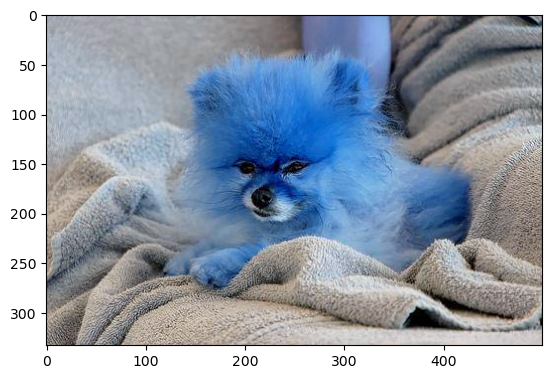

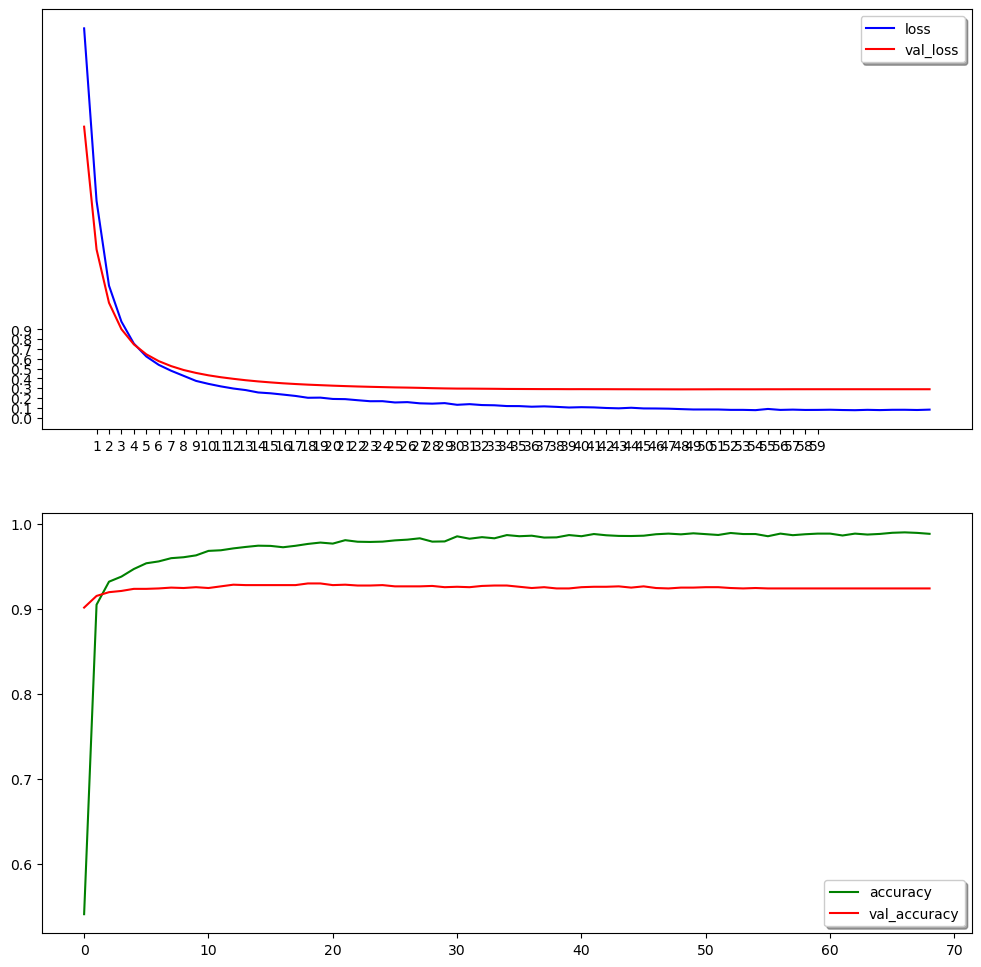

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

# Working with test data

In [48]:
test_data=[]
ids=[]

for pic in os.listdir(test_dir):
    ids.append(pic.split('.')[0])
    test_data.append(test_dir+'/'+pic)

In [49]:
ids[0]

'000621fb3cbb32d8935728e48679680e'

In [50]:
test_data[0]

'../Downloads/dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg'

In [51]:
test_dataframe=pd.DataFrame({'file_name':test_data})
test_dataframe

file_name
0      ../Downloads/dog-breed-identification/test/000...
1      ../Downloads/dog-breed-identification/test/001...
2      ../Downloads/dog-breed-identification/test/001...
3      ../Downloads/dog-breed-identification/test/001...
4      ../Downloads/dog-breed-identification/test/001...
...                                                  ...
10352  ../Downloads/dog-breed-identification/test/ffe...
10353  ../Downloads/dog-breed-identification/test/fff...
10354  ../Downloads/dog-breed-identification/test/fff...
10355  ../Downloads/dog-breed-identification/test/fff...
10356  ../Downloads/dog-breed-identification/test/fff...

[10357 rows x 1 columns]

In [52]:
test_features=feature_extractor(test_dataframe)

  0%|                                                                                          | 0/471 [00:00<?, ?it/s]

Found 10357 validated image filenames.
1/1 [==============================] - 9s 9s/step


  0%|▏                                                                               | 1/471 [00:08<1:10:03,  8.94s/it]

1/1 [==============================] - 8s 8s/step


  0%|▎                                                                               | 2/471 [00:17<1:09:10,  8.85s/it]

1/1 [==============================] - 8s 8s/step


  1%|▌                                                                               | 3/471 [00:26<1:08:11,  8.74s/it]

1/1 [==============================] - 8s 8s/step


  1%|▋                                                                               | 4/471 [00:34<1:06:45,  8.58s/it]

1/1 [==============================] - 8s 8s/step


  1%|▊                                                                               | 5/471 [00:42<1:05:45,  8.47s/it]

1/1 [==============================] - 8s 8s/step


  1%|█                                                                               | 6/471 [00:50<1:05:07,  8.40s/it]

1/1 [==============================] - 9s 9s/step


  1%|█▏                                                                              | 7/471 [00:59<1:05:44,  8.50s/it]

1/1 [==============================] - 9s 9s/step


  2%|█▎                                                                              | 8/471 [01:08<1:06:50,  8.66s/it]

1/1 [==============================] - 8s 8s/step


  2%|█▌                                                                              | 9/471 [01:17<1:06:28,  8.63s/it]

1/1 [==============================] - 8s 8s/step


  2%|█▋                                                                             | 10/471 [01:25<1:06:13,  8.62s/it]

1/1 [==============================] - 8s 8s/step


  2%|█▊                                                                             | 11/471 [01:33<1:05:22,  8.53s/it]

1/1 [==============================] - 8s 8s/step


  3%|██                                                                             | 12/471 [01:42<1:04:51,  8.48s/it]

1/1 [==============================] - 8s 8s/step


  3%|██▏                                                                            | 13/471 [01:50<1:04:11,  8.41s/it]

1/1 [==============================] - 8s 8s/step


  3%|██▎                                                                            | 14/471 [01:58<1:03:57,  8.40s/it]

1/1 [==============================] - 9s 9s/step


  3%|██▌                                                                            | 15/471 [02:07<1:04:32,  8.49s/it]

1/1 [==============================] - 9s 9s/step


  3%|██▋                                                                            | 16/471 [02:16<1:05:15,  8.61s/it]

1/1 [==============================] - 9s 9s/step


  4%|██▊                                                                            | 17/471 [02:25<1:05:36,  8.67s/it]

1/1 [==============================] - 9s 9s/step


  4%|███                                                                            | 18/471 [02:34<1:05:48,  8.72s/it]

1/1 [==============================] - 9s 9s/step


  4%|███▏                                                                           | 19/471 [02:43<1:07:11,  8.92s/it]

1/1 [==============================] - 8s 8s/step


  4%|███▎                                                                           | 20/471 [02:51<1:05:48,  8.76s/it]

1/1 [==============================] - 8s 8s/step


  4%|███▌                                                                           | 21/471 [03:00<1:04:48,  8.64s/it]

1/1 [==============================] - 8s 8s/step


  5%|███▋                                                                           | 22/471 [03:08<1:03:52,  8.54s/it]

1/1 [==============================] - 8s 8s/step


  5%|███▊                                                                           | 23/471 [03:16<1:02:42,  8.40s/it]

1/1 [==============================] - 8s 8s/step


  5%|████                                                                           | 24/471 [03:24<1:02:01,  8.32s/it]

1/1 [==============================] - 8s 8s/step


  5%|████▏                                                                          | 25/471 [03:33<1:01:46,  8.31s/it]

1/1 [==============================] - 9s 9s/step


  6%|████▎                                                                          | 26/471 [03:41<1:02:27,  8.42s/it]

1/1 [==============================] - 8s 8s/step


  6%|████▌                                                                          | 27/471 [03:49<1:01:51,  8.36s/it]

1/1 [==============================] - 8s 8s/step


  6%|████▋                                                                          | 28/471 [03:58<1:01:12,  8.29s/it]

1/1 [==============================] - 8s 8s/step


  6%|████▊                                                                          | 29/471 [04:06<1:00:52,  8.26s/it]

1/1 [==============================] - 8s 8s/step


  6%|█████                                                                          | 30/471 [04:14<1:00:23,  8.22s/it]

1/1 [==============================] - 8s 8s/step


  7%|█████▏                                                                         | 31/471 [04:22<1:00:04,  8.19s/it]

1/1 [==============================] - 8s 8s/step


  7%|█████▌                                                                           | 32/471 [04:30<59:38,  8.15s/it]

1/1 [==============================] - 8s 8s/step


  7%|█████▋                                                                           | 33/471 [04:38<59:30,  8.15s/it]

1/1 [==============================] - 8s 8s/step


  7%|█████▊                                                                           | 34/471 [04:46<59:22,  8.15s/it]

1/1 [==============================] - 8s 8s/step


  7%|██████                                                                           | 35/471 [04:55<59:26,  8.18s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████▏                                                                          | 36/471 [05:03<59:54,  8.26s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████▎                                                                          | 37/471 [05:11<59:41,  8.25s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████▌                                                                          | 38/471 [05:20<59:32,  8.25s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████▋                                                                          | 39/471 [05:28<58:59,  8.19s/it]

1/1 [==============================] - 8s 8s/step


  8%|██████▉                                                                          | 40/471 [05:36<58:43,  8.18s/it]

1/1 [==============================] - 8s 8s/step


  9%|███████                                                                          | 41/471 [05:44<58:38,  8.18s/it]

1/1 [==============================] - 8s 8s/step


  9%|███████▏                                                                         | 42/471 [05:52<58:15,  8.15s/it]

1/1 [==============================] - 8s 8s/step


  9%|███████▍                                                                         | 43/471 [06:01<58:43,  8.23s/it]

1/1 [==============================] - 8s 8s/step


  9%|███████▌                                                                         | 44/471 [06:09<59:13,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 10%|███████▋                                                                         | 45/471 [06:17<58:40,  8.26s/it]

1/1 [==============================] - 8s 8s/step


 10%|███████▉                                                                         | 46/471 [06:25<58:20,  8.24s/it]

1/1 [==============================] - 8s 8s/step


 10%|████████                                                                         | 47/471 [06:33<57:58,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 10%|████████▎                                                                        | 48/471 [06:42<57:41,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 10%|████████▍                                                                        | 49/471 [06:50<57:39,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 11%|████████▌                                                                        | 50/471 [06:58<57:22,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 11%|████████▊                                                                        | 51/471 [07:06<57:46,  8.25s/it]

1/1 [==============================] - 8s 8s/step


 11%|████████▉                                                                        | 52/471 [07:15<57:29,  8.23s/it]

1/1 [==============================] - 8s 8s/step


 11%|█████████                                                                        | 53/471 [07:23<57:17,  8.22s/it]

1/1 [==============================] - 8s 8s/step


 11%|█████████▎                                                                       | 54/471 [07:31<56:53,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 12%|█████████▍                                                                       | 55/471 [07:39<56:49,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 12%|█████████▋                                                                       | 56/471 [07:48<57:23,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 12%|█████████▊                                                                       | 57/471 [07:56<56:48,  8.23s/it]

1/1 [==============================] - 8s 8s/step


 12%|█████████▉                                                                       | 58/471 [08:04<56:27,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▏                                                                      | 59/471 [08:12<56:34,  8.24s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▎                                                                      | 60/471 [08:20<56:30,  8.25s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▍                                                                      | 61/471 [08:28<55:57,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▋                                                                      | 62/471 [08:37<55:27,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 13%|██████████▊                                                                      | 63/471 [08:45<55:16,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████                                                                      | 64/471 [08:53<55:33,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████▏                                                                     | 65/471 [09:01<55:17,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████▎                                                                     | 66/471 [09:09<55:01,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████▌                                                                     | 67/471 [09:17<54:52,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 14%|███████████▋                                                                     | 68/471 [09:25<54:35,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 15%|███████████▊                                                                     | 69/471 [09:34<54:35,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 15%|████████████                                                                     | 70/471 [09:42<54:19,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 15%|████████████▏                                                                    | 71/471 [09:50<54:21,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 15%|████████████▍                                                                    | 72/471 [09:58<54:43,  8.23s/it]

1/1 [==============================] - 8s 8s/step


 15%|████████████▌                                                                    | 73/471 [10:06<54:18,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 16%|████████████▋                                                                    | 74/471 [10:14<54:00,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 16%|████████████▉                                                                    | 75/471 [10:23<54:23,  8.24s/it]

1/1 [==============================] - 8s 8s/step


 16%|█████████████                                                                    | 76/471 [10:31<54:37,  8.30s/it]

1/1 [==============================] - 8s 8s/step


 16%|█████████████▏                                                                   | 77/471 [10:40<54:47,  8.34s/it]

1/1 [==============================] - 9s 9s/step


 17%|█████████████▍                                                                   | 78/471 [10:48<55:18,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 17%|█████████████▌                                                                   | 79/471 [10:57<55:29,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 17%|█████████████▊                                                                   | 80/471 [11:06<55:12,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 17%|█████████████▉                                                                   | 81/471 [11:14<55:09,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 17%|██████████████                                                                   | 82/471 [11:23<55:20,  8.53s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▎                                                                  | 83/471 [11:31<54:56,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▍                                                                  | 84/471 [11:40<54:57,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▌                                                                  | 85/471 [11:48<55:12,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▊                                                                  | 86/471 [11:57<54:47,  8.54s/it]

1/1 [==============================] - 8s 8s/step


 18%|██████████████▉                                                                  | 87/471 [12:05<54:32,  8.52s/it]

1/1 [==============================] - 9s 9s/step


 19%|███████████████▏                                                                 | 88/471 [12:14<55:18,  8.67s/it]

1/1 [==============================] - 8s 8s/step


 19%|███████████████▎                                                                 | 89/471 [12:23<55:08,  8.66s/it]

1/1 [==============================] - 8s 8s/step


 19%|███████████████▍                                                                 | 90/471 [12:31<54:45,  8.62s/it]

1/1 [==============================] - 8s 8s/step


 19%|███████████████▋                                                                 | 91/471 [12:40<54:47,  8.65s/it]

1/1 [==============================] - 8s 8s/step


 20%|███████████████▊                                                                 | 92/471 [12:49<54:19,  8.60s/it]

1/1 [==============================] - 8s 8s/step


 20%|███████████████▉                                                                 | 93/471 [12:57<54:01,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 20%|████████████████▏                                                                | 94/471 [13:06<53:52,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 20%|████████████████▎                                                                | 95/471 [13:14<53:35,  8.55s/it]

1/1 [==============================] - 8s 8s/step


 20%|████████████████▌                                                                | 96/471 [13:23<53:25,  8.55s/it]

1/1 [==============================] - 8s 8s/step


 21%|████████████████▋                                                                | 97/471 [13:31<53:07,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 21%|████████████████▊                                                                | 98/471 [13:40<53:09,  8.55s/it]

1/1 [==============================] - 8s 8s/step


 21%|█████████████████                                                                | 99/471 [13:48<53:04,  8.56s/it]

1/1 [==============================] - 9s 9s/step


 21%|████████████████▉                                                               | 100/471 [13:58<53:55,  8.72s/it]

1/1 [==============================] - 8s 8s/step


 21%|█████████████████▏                                                              | 101/471 [14:06<53:33,  8.69s/it]

1/1 [==============================] - 8s 8s/step


 22%|█████████████████▎                                                              | 102/471 [14:15<53:07,  8.64s/it]

1/1 [==============================] - 8s 8s/step


 22%|█████████████████▍                                                              | 103/471 [14:23<52:43,  8.60s/it]

1/1 [==============================] - 9s 9s/step


 22%|█████████████████▋                                                              | 104/471 [14:32<52:59,  8.66s/it]

1/1 [==============================] - 8s 8s/step


 22%|█████████████████▊                                                              | 105/471 [14:41<52:44,  8.65s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████                                                              | 106/471 [14:49<52:20,  8.60s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████▏                                                             | 107/471 [14:58<52:03,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████▎                                                             | 108/471 [15:06<51:45,  8.55s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████▌                                                             | 109/471 [15:15<51:30,  8.54s/it]

1/1 [==============================] - 8s 8s/step


 23%|██████████████████▋                                                             | 110/471 [15:23<51:29,  8.56s/it]

1/1 [==============================] - 9s 9s/step


 24%|██████████████████▊                                                             | 111/471 [15:32<51:46,  8.63s/it]

1/1 [==============================] - 9s 9s/step


 24%|███████████████████                                                             | 112/471 [15:41<52:27,  8.77s/it]

1/1 [==============================] - 9s 9s/step


 24%|███████████████████▏                                                            | 113/471 [15:50<53:04,  8.90s/it]

1/1 [==============================] - 9s 9s/step


 24%|███████████████████▎                                                            | 114/471 [15:59<52:47,  8.87s/it]

1/1 [==============================] - 8s 8s/step


 24%|███████████████████▌                                                            | 115/471 [16:08<52:01,  8.77s/it]

1/1 [==============================] - 8s 8s/step


 25%|███████████████████▋                                                            | 116/471 [16:16<51:31,  8.71s/it]

1/1 [==============================] - 8s 8s/step


 25%|███████████████████▊                                                            | 117/471 [16:25<51:09,  8.67s/it]

1/1 [==============================] - 9s 9s/step


 25%|████████████████████                                                            | 118/471 [16:34<51:30,  8.76s/it]

1/1 [==============================] - 9s 9s/step


 25%|████████████████████▏                                                           | 119/471 [16:43<51:39,  8.81s/it]

1/1 [==============================] - 9s 9s/step


 25%|████████████████████▍                                                           | 120/471 [16:52<51:52,  8.87s/it]

1/1 [==============================] - 9s 9s/step


 26%|████████████████████▌                                                           | 121/471 [17:01<51:41,  8.86s/it]

1/1 [==============================] - 8s 8s/step


 26%|████████████████████▋                                                           | 122/471 [17:09<50:56,  8.76s/it]

1/1 [==============================] - 8s 8s/step


 26%|████████████████████▉                                                           | 123/471 [17:18<50:22,  8.69s/it]

1/1 [==============================] - 8s 8s/step


 26%|█████████████████████                                                           | 124/471 [17:26<49:51,  8.62s/it]

1/1 [==============================] - 9s 9s/step


 27%|█████████████████████▏                                                          | 125/471 [17:35<50:13,  8.71s/it]

1/1 [==============================] - 9s 9s/step


 27%|█████████████████████▍                                                          | 126/471 [17:44<50:37,  8.81s/it]

1/1 [==============================] - 9s 9s/step


 27%|█████████████████████▌                                                          | 127/471 [17:53<50:45,  8.85s/it]

1/1 [==============================] - 9s 9s/step


 27%|█████████████████████▋                                                          | 128/471 [18:02<51:19,  8.98s/it]

1/1 [==============================] - 9s 9s/step


 27%|█████████████████████▉                                                          | 129/471 [18:11<51:03,  8.96s/it]

1/1 [==============================] - 9s 9s/step


 28%|██████████████████████                                                          | 130/471 [18:20<50:49,  8.94s/it]

1/1 [==============================] - 9s 9s/step


 28%|██████████████████████▎                                                         | 131/471 [18:29<50:40,  8.94s/it]

1/1 [==============================] - 8s 8s/step


 28%|██████████████████████▍                                                         | 132/471 [18:38<50:02,  8.86s/it]

1/1 [==============================] - 8s 8s/step


 28%|██████████████████████▌                                                         | 133/471 [18:46<49:26,  8.78s/it]

1/1 [==============================] - 8s 8s/step


 28%|██████████████████████▊                                                         | 134/471 [18:55<48:50,  8.70s/it]

1/1 [==============================] - 8s 8s/step


 29%|██████████████████████▉                                                         | 135/471 [19:03<48:40,  8.69s/it]

1/1 [==============================] - 8s 8s/step


 29%|███████████████████████                                                         | 136/471 [19:12<48:09,  8.63s/it]

1/1 [==============================] - 8s 8s/step


 29%|███████████████████████▎                                                        | 137/471 [19:20<47:52,  8.60s/it]

1/1 [==============================] - 8s 8s/step


 29%|███████████████████████▍                                                        | 138/471 [19:29<47:38,  8.58s/it]

1/1 [==============================] - 9s 9s/step


 30%|███████████████████████▌                                                        | 139/471 [19:38<48:22,  8.74s/it]

1/1 [==============================] - 9s 9s/step


 30%|███████████████████████▊                                                        | 140/471 [19:47<48:25,  8.78s/it]

1/1 [==============================] - 9s 9s/step


 30%|███████████████████████▉                                                        | 141/471 [19:56<48:28,  8.81s/it]

1/1 [==============================] - 8s 8s/step


 30%|████████████████████████                                                        | 142/471 [20:05<48:12,  8.79s/it]

1/1 [==============================] - 8s 8s/step


 30%|████████████████████████▎                                                       | 143/471 [20:13<47:31,  8.69s/it]

1/1 [==============================] - 8s 8s/step


 31%|████████████████████████▍                                                       | 144/471 [20:22<47:05,  8.64s/it]

1/1 [==============================] - 8s 8s/step


 31%|████████████████████████▋                                                       | 145/471 [20:30<46:54,  8.63s/it]

1/1 [==============================] - 8s 8s/step


 31%|████████████████████████▊                                                       | 146/471 [20:39<46:28,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 31%|████████████████████████▉                                                       | 147/471 [20:47<46:21,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 31%|█████████████████████████▏                                                      | 148/471 [20:56<46:03,  8.56s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▎                                                      | 149/471 [21:04<45:46,  8.53s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▍                                                      | 150/471 [21:13<45:37,  8.53s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▋                                                      | 151/471 [21:21<45:28,  8.53s/it]

1/1 [==============================] - 8s 8s/step


 32%|█████████████████████████▊                                                      | 152/471 [21:30<45:28,  8.55s/it]

1/1 [==============================] - 9s 9s/step


 32%|█████████████████████████▉                                                      | 153/471 [21:39<46:08,  8.71s/it]

1/1 [==============================] - 9s 9s/step


 33%|██████████████████████████▏                                                     | 154/471 [21:48<46:47,  8.86s/it]

1/1 [==============================] - 8s 8s/step


 33%|██████████████████████████▎                                                     | 155/471 [21:57<46:11,  8.77s/it]

1/1 [==============================] - 8s 8s/step


 33%|██████████████████████████▍                                                     | 156/471 [22:05<45:31,  8.67s/it]

1/1 [==============================] - 8s 8s/step


 33%|██████████████████████████▋                                                     | 157/471 [22:14<45:08,  8.63s/it]

1/1 [==============================] - 8s 8s/step


 34%|██████████████████████████▊                                                     | 158/471 [22:22<44:48,  8.59s/it]

1/1 [==============================] - 8s 8s/step


 34%|███████████████████████████                                                     | 159/471 [22:31<44:22,  8.53s/it]

1/1 [==============================] - 8s 8s/step


 34%|███████████████████████████▏                                                    | 160/471 [22:39<44:07,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 34%|███████████████████████████▎                                                    | 161/471 [22:48<43:53,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 34%|███████████████████████████▌                                                    | 162/471 [22:56<43:38,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 35%|███████████████████████████▋                                                    | 163/471 [23:04<43:34,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 35%|███████████████████████████▊                                                    | 164/471 [23:13<43:24,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 35%|████████████████████████████                                                    | 165/471 [23:22<43:28,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 35%|████████████████████████████▏                                                   | 166/471 [23:30<43:15,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 35%|████████████████████████████▎                                                   | 167/471 [23:38<43:00,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 36%|████████████████████████████▌                                                   | 168/471 [23:47<42:48,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 36%|████████████████████████████▋                                                   | 169/471 [23:55<42:44,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 36%|████████████████████████████▊                                                   | 170/471 [24:04<42:33,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 36%|█████████████████████████████                                                   | 171/471 [24:12<42:24,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▏                                                  | 172/471 [24:21<42:17,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▍                                                  | 173/471 [24:29<42:06,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▌                                                  | 174/471 [24:38<41:53,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▋                                                  | 175/471 [24:46<41:49,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 37%|█████████████████████████████▉                                                  | 176/471 [24:55<41:46,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████                                                  | 177/471 [25:03<41:32,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████▏                                                 | 178/471 [25:12<41:25,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████▍                                                 | 179/471 [25:20<41:24,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████▌                                                 | 180/471 [25:29<41:10,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 38%|██████████████████████████████▋                                                 | 181/471 [25:37<41:12,  8.53s/it]

1/1 [==============================] - 8s 8s/step


 39%|██████████████████████████████▉                                                 | 182/471 [25:46<41:01,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 39%|███████████████████████████████                                                 | 183/471 [25:55<41:10,  8.58s/it]

1/1 [==============================] - 8s 8s/step


 39%|███████████████████████████████▎                                                | 184/471 [26:03<40:53,  8.55s/it]

1/1 [==============================] - 8s 8s/step


 39%|███████████████████████████████▍                                                | 185/471 [26:12<40:41,  8.54s/it]

1/1 [==============================] - 8s 8s/step


 39%|███████████████████████████████▌                                                | 186/471 [26:20<40:26,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 40%|███████████████████████████████▊                                                | 187/471 [26:29<40:16,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 40%|███████████████████████████████▉                                                | 188/471 [26:37<40:12,  8.52s/it]

1/1 [==============================] - 9s 9s/step


 40%|████████████████████████████████                                                | 189/471 [26:46<40:21,  8.59s/it]

1/1 [==============================] - 9s 9s/step


 40%|████████████████████████████████▎                                               | 190/471 [26:55<40:37,  8.67s/it]

1/1 [==============================] - 8s 8s/step


 41%|████████████████████████████████▍                                               | 191/471 [27:03<40:24,  8.66s/it]

1/1 [==============================] - 8s 8s/step


 41%|████████████████████████████████▌                                               | 192/471 [27:12<39:56,  8.59s/it]

1/1 [==============================] - 8s 8s/step


 41%|████████████████████████████████▊                                               | 193/471 [27:20<39:50,  8.60s/it]

1/1 [==============================] - 8s 8s/step


 41%|████████████████████████████████▉                                               | 194/471 [27:29<39:31,  8.56s/it]

1/1 [==============================] - 8s 8s/step


 41%|█████████████████████████████████                                               | 195/471 [27:37<39:10,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▎                                              | 196/471 [27:46<39:03,  8.52s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▍                                              | 197/471 [27:54<38:50,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▋                                              | 198/471 [28:03<38:37,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▊                                              | 199/471 [28:11<38:28,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 42%|█████████████████████████████████▉                                              | 200/471 [28:20<38:18,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████▏                                             | 201/471 [28:28<38:03,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████▎                                             | 202/471 [28:37<37:54,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████▍                                             | 203/471 [28:45<37:48,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 43%|██████████████████████████████████▋                                             | 204/471 [28:53<37:36,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 44%|██████████████████████████████████▊                                             | 205/471 [29:02<37:28,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 44%|██████████████████████████████████▉                                             | 206/471 [29:10<37:23,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 44%|███████████████████████████████████▏                                            | 207/471 [29:19<37:24,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 44%|███████████████████████████████████▎                                            | 208/471 [29:27<37:15,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 44%|███████████████████████████████████▍                                            | 209/471 [29:36<37:04,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 45%|███████████████████████████████████▋                                            | 210/471 [29:44<36:45,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 45%|███████████████████████████████████▊                                            | 211/471 [29:53<36:37,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 45%|████████████████████████████████████                                            | 212/471 [30:01<36:10,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 45%|████████████████████████████████████▏                                           | 213/471 [30:09<35:48,  8.33s/it]

1/1 [==============================] - 8s 8s/step


 45%|████████████████████████████████████▎                                           | 214/471 [30:18<35:45,  8.35s/it]

1/1 [==============================] - 8s 8s/step


 46%|████████████████████████████████████▌                                           | 215/471 [30:26<35:20,  8.28s/it]

1/1 [==============================] - 8s 8s/step


 46%|████████████████████████████████████▋                                           | 216/471 [30:34<34:59,  8.23s/it]

1/1 [==============================] - 8s 8s/step


 46%|████████████████████████████████████▊                                           | 217/471 [30:42<34:53,  8.24s/it]

1/1 [==============================] - 8s 8s/step


 46%|█████████████████████████████████████                                           | 218/471 [30:50<34:42,  8.23s/it]

1/1 [==============================] - 8s 8s/step


 46%|█████████████████████████████████████▏                                          | 219/471 [30:58<34:26,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 47%|█████████████████████████████████████▎                                          | 220/471 [31:07<34:15,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 47%|█████████████████████████████████████▌                                          | 221/471 [31:15<34:05,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 47%|█████████████████████████████████████▋                                          | 222/471 [31:23<33:59,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 47%|█████████████████████████████████████▉                                          | 223/471 [31:31<33:48,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████                                          | 224/471 [31:39<33:34,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████▏                                         | 225/471 [31:47<33:22,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████▍                                         | 226/471 [31:55<33:11,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████▌                                         | 227/471 [32:04<33:03,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 48%|██████████████████████████████████████▋                                         | 228/471 [32:12<32:56,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 49%|██████████████████████████████████████▉                                         | 229/471 [32:20<32:50,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 49%|███████████████████████████████████████                                         | 230/471 [32:28<32:42,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 49%|███████████████████████████████████████▏                                        | 231/471 [32:36<32:36,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 49%|███████████████████████████████████████▍                                        | 232/471 [32:44<32:25,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 49%|███████████████████████████████████████▌                                        | 233/471 [32:52<32:19,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 50%|███████████████████████████████████████▋                                        | 234/471 [33:01<32:18,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 50%|███████████████████████████████████████▉                                        | 235/471 [33:09<32:02,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 50%|████████████████████████████████████████                                        | 236/471 [33:17<31:58,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 50%|████████████████████████████████████████▎                                       | 237/471 [33:25<31:54,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 51%|████████████████████████████████████████▍                                       | 238/471 [33:33<31:40,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 51%|████████████████████████████████████████▌                                       | 239/471 [33:41<31:31,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 51%|████████████████████████████████████████▊                                       | 240/471 [33:50<31:23,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 51%|████████████████████████████████████████▉                                       | 241/471 [33:58<31:10,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 51%|█████████████████████████████████████████                                       | 242/471 [34:06<31:03,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▎                                      | 243/471 [34:14<31:01,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▍                                      | 244/471 [34:22<31:03,  8.21s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▌                                      | 245/471 [34:31<30:51,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▊                                      | 246/471 [34:39<30:41,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 52%|█████████████████████████████████████████▉                                      | 247/471 [34:47<30:30,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 53%|██████████████████████████████████████████                                      | 248/471 [34:55<30:24,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 53%|██████████████████████████████████████████▎                                     | 249/471 [35:03<30:12,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 53%|██████████████████████████████████████████▍                                     | 250/471 [35:11<30:01,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 53%|██████████████████████████████████████████▋                                     | 251/471 [35:20<30:06,  8.21s/it]

1/1 [==============================] - 8s 8s/step


 54%|██████████████████████████████████████████▊                                     | 252/471 [35:28<29:52,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 54%|██████████████████████████████████████████▉                                     | 253/471 [35:36<29:41,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 54%|███████████████████████████████████████████▏                                    | 254/471 [35:44<29:46,  8.23s/it]

1/1 [==============================] - 8s 8s/step


 54%|███████████████████████████████████████████▎                                    | 255/471 [35:53<29:38,  8.23s/it]

1/1 [==============================] - 8s 8s/step


 54%|███████████████████████████████████████████▍                                    | 256/471 [36:01<29:26,  8.21s/it]

1/1 [==============================] - 8s 8s/step


 55%|███████████████████████████████████████████▋                                    | 257/471 [36:09<29:13,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 55%|███████████████████████████████████████████▊                                    | 258/471 [36:17<29:05,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 55%|███████████████████████████████████████████▉                                    | 259/471 [36:25<28:56,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 55%|████████████████████████████████████████████▏                                   | 260/471 [36:33<28:46,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 55%|████████████████████████████████████████████▎                                   | 261/471 [36:41<28:30,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 56%|████████████████████████████████████████████▌                                   | 262/471 [36:50<28:23,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 56%|████████████████████████████████████████████▋                                   | 263/471 [36:58<28:09,  8.12s/it]

1/1 [==============================] - 8s 8s/step


 56%|████████████████████████████████████████████▊                                   | 264/471 [37:06<28:05,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 56%|█████████████████████████████████████████████                                   | 265/471 [37:14<28:00,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 56%|█████████████████████████████████████████████▏                                  | 266/471 [37:22<27:59,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▎                                  | 267/471 [37:30<27:48,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▌                                  | 268/471 [37:39<27:42,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▋                                  | 269/471 [37:47<27:31,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 57%|█████████████████████████████████████████████▊                                  | 270/471 [37:55<27:19,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████                                  | 271/471 [38:03<27:14,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████▏                                 | 272/471 [38:11<27:00,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████▎                                 | 273/471 [38:19<26:59,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████▌                                 | 274/471 [38:28<26:48,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 58%|██████████████████████████████████████████████▋                                 | 275/471 [38:36<26:37,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 59%|██████████████████████████████████████████████▉                                 | 276/471 [38:44<26:29,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 59%|███████████████████████████████████████████████                                 | 277/471 [38:52<26:18,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 59%|███████████████████████████████████████████████▏                                | 278/471 [39:00<26:09,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 59%|███████████████████████████████████████████████▍                                | 279/471 [39:08<26:04,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 59%|███████████████████████████████████████████████▌                                | 280/471 [39:16<25:58,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 60%|███████████████████████████████████████████████▋                                | 281/471 [39:25<25:55,  8.19s/it]

1/1 [==============================] - 8s 8s/step


 60%|███████████████████████████████████████████████▉                                | 282/471 [39:33<25:45,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 60%|████████████████████████████████████████████████                                | 283/471 [39:41<25:34,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 60%|████████████████████████████████████████████████▏                               | 284/471 [39:49<25:26,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 61%|████████████████████████████████████████████████▍                               | 285/471 [39:57<25:17,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 61%|████████████████████████████████████████████████▌                               | 286/471 [40:05<25:05,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 61%|████████████████████████████████████████████████▋                               | 287/471 [40:14<25:18,  8.25s/it]

1/1 [==============================] - 8s 8s/step


 61%|████████████████████████████████████████████████▉                               | 288/471 [40:22<25:22,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 61%|█████████████████████████████████████████████████                               | 289/471 [40:31<25:21,  8.36s/it]

1/1 [==============================] - 8s 8s/step


 62%|█████████████████████████████████████████████████▎                              | 290/471 [40:39<25:19,  8.39s/it]

1/1 [==============================] - 8s 8s/step


 62%|█████████████████████████████████████████████████▍                              | 291/471 [40:48<25:15,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 62%|█████████████████████████████████████████████████▌                              | 292/471 [40:56<25:15,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 62%|█████████████████████████████████████████████████▊                              | 293/471 [41:05<25:10,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 62%|█████████████████████████████████████████████████▉                              | 294/471 [41:13<25:00,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████                              | 295/471 [41:22<24:57,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████▎                             | 296/471 [41:30<24:45,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████▍                             | 297/471 [41:39<24:35,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████▌                             | 298/471 [41:47<24:23,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 63%|██████████████████████████████████████████████████▊                             | 299/471 [41:56<24:19,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 64%|██████████████████████████████████████████████████▉                             | 300/471 [42:04<24:17,  8.52s/it]

1/1 [==============================] - 9s 9s/step


 64%|███████████████████████████████████████████████████▏                            | 301/471 [42:13<24:21,  8.59s/it]

1/1 [==============================] - 8s 8s/step


 64%|███████████████████████████████████████████████████▎                            | 302/471 [42:22<24:04,  8.55s/it]

1/1 [==============================] - 8s 8s/step


 64%|███████████████████████████████████████████████████▍                            | 303/471 [42:30<23:50,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 65%|███████████████████████████████████████████████████▋                            | 304/471 [42:38<23:35,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 65%|███████████████████████████████████████████████████▊                            | 305/471 [42:47<23:24,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 65%|███████████████████████████████████████████████████▉                            | 306/471 [42:55<23:17,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 65%|████████████████████████████████████████████████████▏                           | 307/471 [43:04<23:03,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 65%|████████████████████████████████████████████████████▎                           | 308/471 [43:12<22:54,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 66%|████████████████████████████████████████████████████▍                           | 309/471 [43:21<22:56,  8.50s/it]

1/1 [==============================] - 8s 8s/step


 66%|████████████████████████████████████████████████████▋                           | 310/471 [43:29<22:46,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 66%|████████████████████████████████████████████████████▊                           | 311/471 [43:38<22:38,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 66%|████████████████████████████████████████████████████▉                           | 312/471 [43:46<22:29,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 66%|█████████████████████████████████████████████████████▏                          | 313/471 [43:55<22:15,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 67%|█████████████████████████████████████████████████████▎                          | 314/471 [44:03<22:06,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 67%|█████████████████████████████████████████████████████▌                          | 315/471 [44:12<21:59,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 67%|█████████████████████████████████████████████████████▋                          | 316/471 [44:20<21:49,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 67%|█████████████████████████████████████████████████████▊                          | 317/471 [44:28<21:42,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████                          | 318/471 [44:37<21:31,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████▏                         | 319/471 [44:45<21:19,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████▎                         | 320/471 [44:54<21:12,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████▌                         | 321/471 [45:02<21:06,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 68%|██████████████████████████████████████████████████████▋                         | 322/471 [45:11<20:55,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 69%|██████████████████████████████████████████████████████▊                         | 323/471 [45:19<20:55,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 69%|███████████████████████████████████████████████████████                         | 324/471 [45:28<20:47,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 69%|███████████████████████████████████████████████████████▏                        | 325/471 [45:36<20:37,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 69%|███████████████████████████████████████████████████████▎                        | 326/471 [45:45<20:28,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 69%|███████████████████████████████████████████████████████▌                        | 327/471 [45:53<20:18,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 70%|███████████████████████████████████████████████████████▋                        | 328/471 [46:01<20:08,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 70%|███████████████████████████████████████████████████████▉                        | 329/471 [46:10<19:58,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 70%|████████████████████████████████████████████████████████                        | 330/471 [46:18<19:53,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 70%|████████████████████████████████████████████████████████▏                       | 331/471 [46:27<19:43,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 70%|████████████████████████████████████████████████████████▍                       | 332/471 [46:35<19:36,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 71%|████████████████████████████████████████████████████████▌                       | 333/471 [46:44<19:30,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 71%|████████████████████████████████████████████████████████▋                       | 334/471 [46:52<19:17,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 71%|████████████████████████████████████████████████████████▉                       | 335/471 [47:01<19:10,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 71%|█████████████████████████████████████████████████████████                       | 336/471 [47:09<19:02,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▏                      | 337/471 [47:18<18:54,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▍                      | 338/471 [47:26<18:48,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▌                      | 339/471 [47:35<18:41,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▋                      | 340/471 [47:43<18:29,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 72%|█████████████████████████████████████████████████████████▉                      | 341/471 [47:52<18:22,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 73%|██████████████████████████████████████████████████████████                      | 342/471 [48:00<18:12,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 73%|██████████████████████████████████████████████████████████▎                     | 343/471 [48:08<18:01,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 73%|██████████████████████████████████████████████████████████▍                     | 344/471 [48:17<17:54,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 73%|██████████████████████████████████████████████████████████▌                     | 345/471 [48:25<17:47,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 73%|██████████████████████████████████████████████████████████▊                     | 346/471 [48:34<17:35,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 74%|██████████████████████████████████████████████████████████▉                     | 347/471 [48:42<17:27,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 74%|███████████████████████████████████████████████████████████                     | 348/471 [48:51<17:17,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 74%|███████████████████████████████████████████████████████████▎                    | 349/471 [48:59<17:07,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 74%|███████████████████████████████████████████████████████████▍                    | 350/471 [49:07<16:59,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 75%|███████████████████████████████████████████████████████████▌                    | 351/471 [49:16<16:53,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 75%|███████████████████████████████████████████████████████████▊                    | 352/471 [49:24<16:49,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 75%|███████████████████████████████████████████████████████████▉                    | 353/471 [49:33<16:41,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 75%|████████████████████████████████████████████████████████████▏                   | 354/471 [49:41<16:33,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 75%|████████████████████████████████████████████████████████████▎                   | 355/471 [49:50<16:22,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 76%|████████████████████████████████████████████████████████████▍                   | 356/471 [49:58<16:11,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 76%|████████████████████████████████████████████████████████████▋                   | 357/471 [50:07<16:02,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 76%|████████████████████████████████████████████████████████████▊                   | 358/471 [50:15<15:54,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 76%|████████████████████████████████████████████████████████████▉                   | 359/471 [50:24<15:46,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 76%|█████████████████████████████████████████████████████████████▏                  | 360/471 [50:32<15:37,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▎                  | 361/471 [50:41<15:28,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▍                  | 362/471 [50:49<15:21,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▋                  | 363/471 [50:57<15:11,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▊                  | 364/471 [51:06<15:02,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 77%|█████████████████████████████████████████████████████████████▉                  | 365/471 [51:14<14:56,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████▏                 | 366/471 [51:23<14:50,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████▎                 | 367/471 [51:31<14:40,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████▌                 | 368/471 [51:40<14:33,  8.48s/it]

1/1 [==============================] - 8s 8s/step


 78%|██████████████████████████████████████████████████████████████▋                 | 369/471 [51:48<14:27,  8.51s/it]

1/1 [==============================] - 8s 8s/step


 79%|██████████████████████████████████████████████████████████████▊                 | 370/471 [51:57<14:15,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 79%|███████████████████████████████████████████████████████████████                 | 371/471 [52:05<14:05,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 79%|███████████████████████████████████████████████████████████████▏                | 372/471 [52:14<13:57,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 79%|███████████████████████████████████████████████████████████████▎                | 373/471 [52:22<13:48,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 79%|███████████████████████████████████████████████████████████████▌                | 374/471 [52:31<13:40,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 80%|███████████████████████████████████████████████████████████████▋                | 375/471 [52:39<13:30,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 80%|███████████████████████████████████████████████████████████████▊                | 376/471 [52:47<13:22,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 80%|████████████████████████████████████████████████████████████████                | 377/471 [52:56<13:13,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 80%|████████████████████████████████████████████████████████████████▏               | 378/471 [53:04<13:05,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 80%|████████████████████████████████████████████████████████████████▎               | 379/471 [53:13<12:55,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 81%|████████████████████████████████████████████████████████████████▌               | 380/471 [53:21<12:52,  8.49s/it]

1/1 [==============================] - 8s 8s/step


 81%|████████████████████████████████████████████████████████████████▋               | 381/471 [53:30<12:41,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 81%|████████████████████████████████████████████████████████████████▉               | 382/471 [53:38<12:33,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 81%|█████████████████████████████████████████████████████████████████               | 383/471 [53:47<12:24,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 82%|█████████████████████████████████████████████████████████████████▏              | 384/471 [53:55<12:14,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 82%|█████████████████████████████████████████████████████████████████▍              | 385/471 [54:04<12:06,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 82%|█████████████████████████████████████████████████████████████████▌              | 386/471 [54:12<11:57,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 82%|█████████████████████████████████████████████████████████████████▋              | 387/471 [54:20<11:48,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 82%|█████████████████████████████████████████████████████████████████▉              | 388/471 [54:29<11:40,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 83%|██████████████████████████████████████████████████████████████████              | 389/471 [54:37<11:32,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 83%|██████████████████████████████████████████████████████████████████▏             | 390/471 [54:46<11:22,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 83%|██████████████████████████████████████████████████████████████████▍             | 391/471 [54:54<11:13,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 83%|██████████████████████████████████████████████████████████████████▌             | 392/471 [55:03<11:07,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 83%|██████████████████████████████████████████████████████████████████▊             | 393/471 [55:11<10:58,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 84%|██████████████████████████████████████████████████████████████████▉             | 394/471 [55:20<10:51,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 84%|███████████████████████████████████████████████████████████████████             | 395/471 [55:28<10:43,  8.47s/it]

1/1 [==============================] - 8s 8s/step


 84%|███████████████████████████████████████████████████████████████████▎            | 396/471 [55:36<10:33,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 84%|███████████████████████████████████████████████████████████████████▍            | 397/471 [55:45<10:25,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 85%|███████████████████████████████████████████████████████████████████▌            | 398/471 [55:53<10:16,  8.45s/it]

1/1 [==============================] - 8s 8s/step


 85%|███████████████████████████████████████████████████████████████████▊            | 399/471 [56:02<10:07,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 85%|███████████████████████████████████████████████████████████████████▉            | 400/471 [56:10<09:57,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 85%|████████████████████████████████████████████████████████████████████            | 401/471 [56:19<09:51,  8.46s/it]

1/1 [==============================] - 8s 8s/step


 85%|████████████████████████████████████████████████████████████████████▎           | 402/471 [56:27<09:41,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 86%|████████████████████████████████████████████████████████████████████▍           | 403/471 [56:35<09:32,  8.42s/it]

1/1 [==============================] - 8s 8s/step


 86%|████████████████████████████████████████████████████████████████████▌           | 404/471 [56:44<09:25,  8.44s/it]

1/1 [==============================] - 8s 8s/step


 86%|████████████████████████████████████████████████████████████████████▊           | 405/471 [56:52<09:13,  8.38s/it]

1/1 [==============================] - 8s 8s/step


 86%|████████████████████████████████████████████████████████████████████▉           | 406/471 [57:00<08:58,  8.29s/it]

1/1 [==============================] - 8s 8s/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 407/471 [57:08<08:47,  8.24s/it]

1/1 [==============================] - 8s 8s/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 408/471 [57:17<08:40,  8.26s/it]

1/1 [==============================] - 8s 8s/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 409/471 [57:25<08:36,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 410/471 [57:33<08:24,  8.28s/it]

1/1 [==============================] - 8s 8s/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 411/471 [57:41<08:14,  8.24s/it]

1/1 [==============================] - 8s 8s/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 412/471 [57:50<08:03,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 413/471 [57:58<07:55,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 414/471 [58:06<07:45,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 415/471 [58:14<07:37,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 416/471 [58:22<07:28,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 417/471 [58:30<07:19,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 418/471 [58:38<07:11,  8.14s/it]

1/1 [==============================] - 8s 8s/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 419/471 [58:46<07:02,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 420/471 [58:55<06:53,  8.10s/it]

1/1 [==============================] - 8s 8s/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 421/471 [59:03<06:45,  8.10s/it]

1/1 [==============================] - 8s 8s/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 422/471 [59:11<06:36,  8.09s/it]

1/1 [==============================] - 8s 8s/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 423/471 [59:19<06:31,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 90%|████████████████████████████████████████████████████████████████████████        | 424/471 [59:27<06:23,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 425/471 [59:35<06:14,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 426/471 [59:43<06:07,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 427/471 [59:52<05:59,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 428/471 [1:00:00<05:50,  8.15s/it]

1/1 [==============================] - 8s 8s/step


 91%|███████████████████████████████████████████████████████████████████████       | 429/471 [1:00:08<05:42,  8.16s/it]

1/1 [==============================] - 8s 8s/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 430/471 [1:00:16<05:35,  8.18s/it]

1/1 [==============================] - 8s 8s/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 431/471 [1:00:24<05:27,  8.20s/it]

1/1 [==============================] - 1583s 1583s/step


 92%|████████████████████████████████████████████████████████████████████▊      | 432/471 [1:26:48<5:12:26, 480.67s/it]

1/1 [==============================] - 8s 8s/step


 92%|████████████████████████████████████████████████████████████████████▉      | 433/471 [1:26:56<3:34:46, 339.12s/it]

1/1 [==============================] - 8s 8s/step


 92%|█████████████████████████████████████████████████████████████████████      | 434/471 [1:27:04<2:27:51, 239.77s/it]

1/1 [==============================] - 9s 9s/step


 92%|█████████████████████████████████████████████████████████████████████▎     | 435/471 [1:27:13<1:42:16, 170.46s/it]

1/1 [==============================] - 8s 8s/step


 93%|█████████████████████████████████████████████████████████████████████▍     | 436/471 [1:27:21<1:11:02, 121.79s/it]

1/1 [==============================] - 8s 8s/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 437/471 [1:27:29<49:39, 87.63s/it]

1/1 [==============================] - 8s 8s/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 438/471 [1:27:37<35:03, 63.75s/it]

1/1 [==============================] - 8s 8s/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 439/471 [1:27:45<25:03, 46.99s/it]

1/1 [==============================] - 8s 8s/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 440/471 [1:27:53<18:14, 35.29s/it]

1/1 [==============================] - 8s 8s/step


 94%|█████████████████████████████████████████████████████████████████████████     | 441/471 [1:28:01<13:33, 27.11s/it]

1/1 [==============================] - 8s 8s/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 442/471 [1:28:09<10:19, 21.36s/it]

1/1 [==============================] - 8s 8s/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 443/471 [1:28:17<08:06, 17.36s/it]

1/1 [==============================] - 8s 8s/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 444/471 [1:28:25<06:33, 14.56s/it]

1/1 [==============================] - 8s 8s/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 445/471 [1:28:33<05:27, 12.59s/it]

1/1 [==============================] - 8s 8s/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 446/471 [1:28:41<04:40, 11.22s/it]

1/1 [==============================] - 8s 8s/step


 95%|██████████████████████████████████████████████████████████████████████████    | 447/471 [1:28:49<04:06, 10.27s/it]

1/1 [==============================] - 8s 8s/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 448/471 [1:28:57<03:40,  9.58s/it]

1/1 [==============================] - 8s 8s/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 449/471 [1:29:05<03:20,  9.12s/it]

1/1 [==============================] - 8s 8s/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 450/471 [1:29:13<03:04,  8.80s/it]

1/1 [==============================] - 8s 8s/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 451/471 [1:29:21<02:51,  8.59s/it]

1/1 [==============================] - 8s 8s/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 452/471 [1:29:29<02:40,  8.43s/it]

1/1 [==============================] - 8s 8s/step


 96%|███████████████████████████████████████████████████████████████████████████   | 453/471 [1:29:37<02:29,  8.32s/it]

1/1 [==============================] - 8s 8s/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 454/471 [1:29:46<02:20,  8.28s/it]

1/1 [==============================] - 8s 8s/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 455/471 [1:29:54<02:11,  8.22s/it]

1/1 [==============================] - 8s 8s/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 456/471 [1:30:02<02:03,  8.21s/it]

1/1 [==============================] - 8s 8s/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 457/471 [1:30:10<01:54,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 458/471 [1:30:19<01:47,  8.26s/it]

1/1 [==============================] - 8s 8s/step


 97%|████████████████████████████████████████████████████████████████████████████  | 459/471 [1:30:27<01:39,  8.28s/it]

1/1 [==============================] - 8s 8s/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 460/471 [1:30:35<01:30,  8.21s/it]

1/1 [==============================] - 8s 8s/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 461/471 [1:30:43<01:21,  8.17s/it]

1/1 [==============================] - 8s 8s/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 462/471 [1:30:51<01:13,  8.13s/it]

1/1 [==============================] - 8s 8s/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 463/471 [1:30:59<01:05,  8.20s/it]

1/1 [==============================] - 8s 8s/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 464/471 [1:31:08<00:57,  8.24s/it]

1/1 [==============================] - 8s 8s/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 465/471 [1:31:16<00:49,  8.24s/it]

1/1 [==============================] - 8s 8s/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 466/471 [1:31:24<00:41,  8.22s/it]

1/1 [==============================] - 8s 8s/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 467/471 [1:31:32<00:32,  8.22s/it]

1/1 [==============================] - 8s 8s/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 468/471 [1:31:40<00:24,  8.18s/it]

1/1 [==============================] - 8s 8s/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 469/471 [1:31:49<00:16,  8.15s/it]

1/1 [==============================] - 8s 8s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 470/471 [1:31:57<00:08,  8.15s/it]

1/1 [==============================] - 6s 6s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 470/471 [1:32:03<00:11, 11.75s/it]


In [53]:
test_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [54]:
test_features.shape

(10357, 9664)

In [55]:
y_pred=nn.predict(test_features)
y_pred

324/324 [==============================] - 1s 2ms/step


array([[1.5777506e-06, 2.2118045e-06, 2.4230860e-06, ..., 1.6344979e-06,
        4.3151217e-06, 1.6067697e-06],
       [7.9272247e-08, 2.3022592e-08, 8.5732708e-08, ..., 7.7704293e-08,
        2.0033646e-08, 2.6344981e-08],
       [4.2465006e-05, 4.3980274e-04, 3.7889113e-04, ..., 1.5212277e-04,
        4.9705981e-05, 6.6151035e-05],
       ...,
       [2.1973990e-06, 1.4082491e-06, 1.7874526e-04, ..., 3.1056222e-06,
        1.4081176e-06, 1.3650142e-06],
       [9.6852076e-05, 9.2800554e-05, 3.2304059e-05, ..., 5.7818899e-05,
        1.4692998e-05, 1.3957317e-04],
       [2.3342404e-06, 9.4167372e-06, 4.2314787e-06, ..., 7.9673657e-05,
        1.3455814e-06, 8.7065871e-07]], dtype=float32)

In [56]:
np.set_printoptions(suppress=True)
y_pred

array([[0.00000158, 0.00000221, 0.00000242, ..., 0.00000163, 0.00000432,
        0.00000161],
       [0.00000008, 0.00000002, 0.00000009, ..., 0.00000008, 0.00000002,
        0.00000003],
       [0.00004247, 0.0004398 , 0.00037889, ..., 0.00015212, 0.00004971,
        0.00006615],
       ...,
       [0.0000022 , 0.00000141, 0.00017875, ..., 0.00000311, 0.00000141,
        0.00000137],
       [0.00009685, 0.0000928 , 0.0000323 , ..., 0.00005782, 0.00001469,
        0.00013957],
       [0.00000233, 0.00000942, 0.00000423, ..., 0.00007967, 0.00000135,
        0.00000087]], dtype=float32)

In [57]:
def get_key(val):
    for key, value in classes_to_num.items():
        if val==value:
            return key
        
pred_codes=np.argmax(y_pred,axis=1)
predictions=[]

for i in pred_codes:
    
    predictions.append(get_key(i))

In [58]:
pred_codes

array([61, 94, 40, ..., 36, 70, 59], dtype=int64)

In [59]:
predictions[:25]

['japanese_spaniel',
 'samoyed',
 'english_setter',
 'pug',
 'shih-tzu',
 'standard_poodle',
 'australian_terrier',
 'samoyed',
 'irish_wolfhound',
 'sussex_spaniel',
 'tibetan_terrier',
 'sealyham_terrier',
 'newfoundland',
 'norwich_terrier',
 'beagle',
 'leonberg',
 'chihuahua',
 'sealyham_terrier',
 'irish_terrier',
 'saluki',
 'scotch_terrier',
 'siberian_husky',
 'mexican_hairless',
 'labrador_retriever',
 'irish_setter']

In [60]:
test_dataframe['breed']=predictions
test_dataframe[:10]

file_name               breed
0  ../Downloads/dog-breed-identification/test/000...    japanese_spaniel
1  ../Downloads/dog-breed-identification/test/001...             samoyed
2  ../Downloads/dog-breed-identification/test/001...      english_setter
3  ../Downloads/dog-breed-identification/test/001...                 pug
4  ../Downloads/dog-breed-identification/test/001...            shih-tzu
5  ../Downloads/dog-breed-identification/test/002...     standard_poodle
6  ../Downloads/dog-breed-identification/test/002...  australian_terrier
7  ../Downloads/dog-breed-identification/test/002...             samoyed
8  ../Downloads/dog-breed-identification/test/002...     irish_wolfhound
9  ../Downloads/dog-breed-identification/test/003...      sussex_spaniel

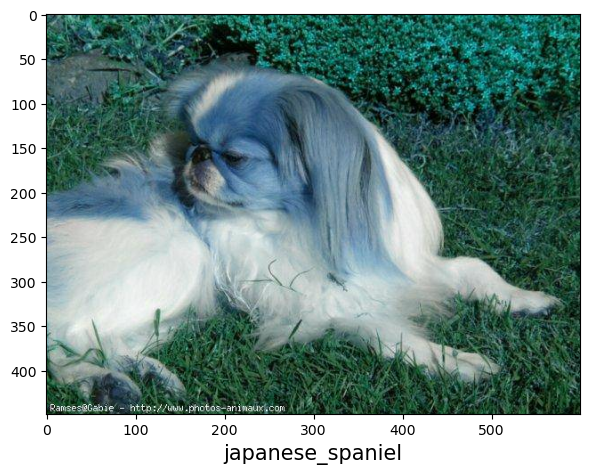

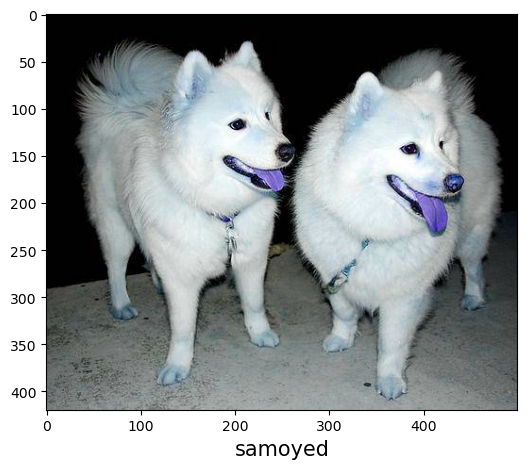

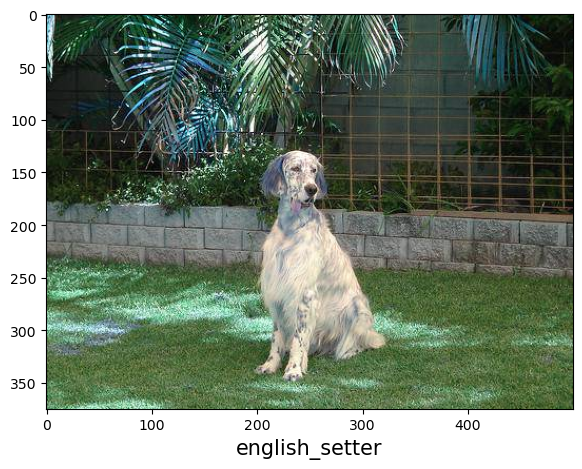

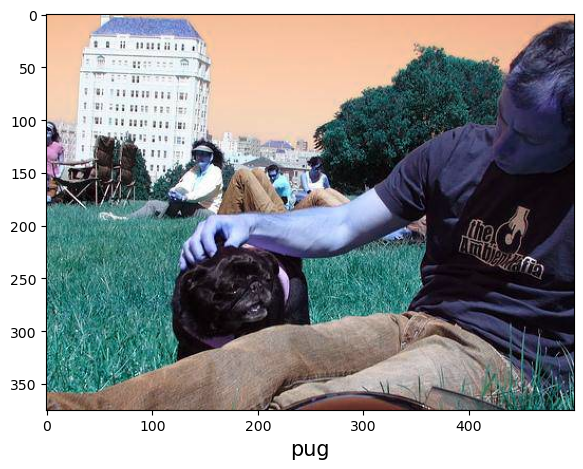

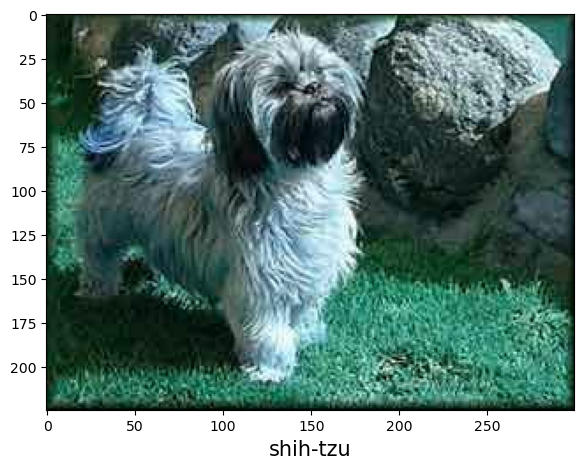

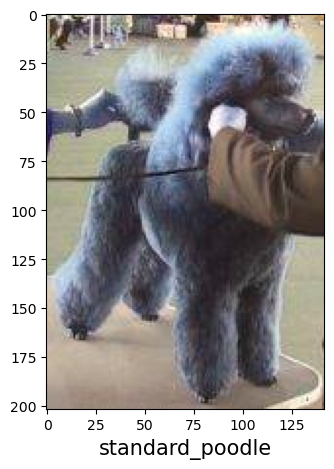

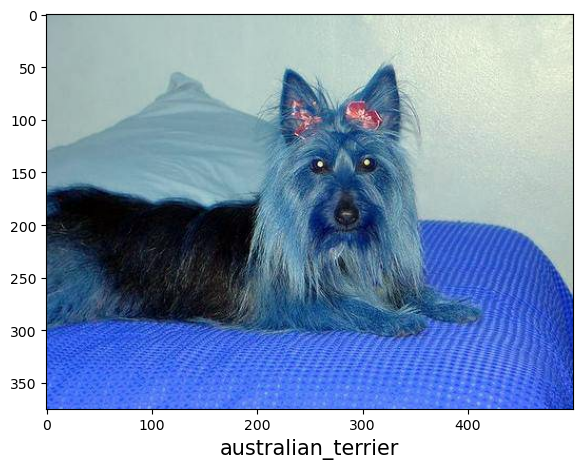

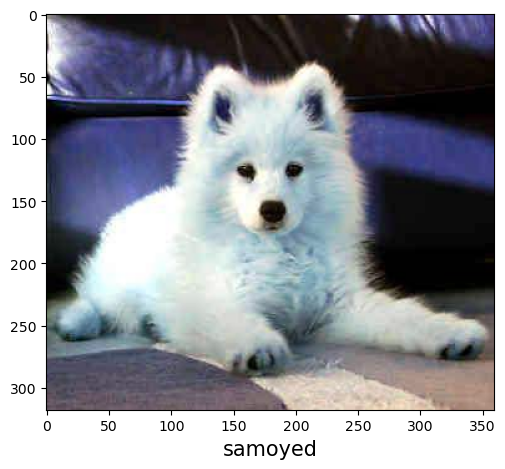

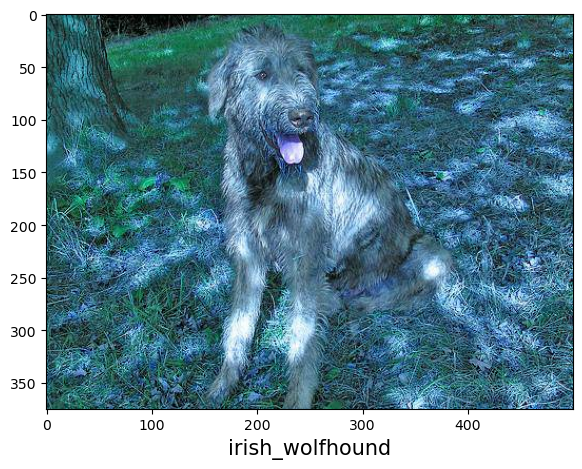

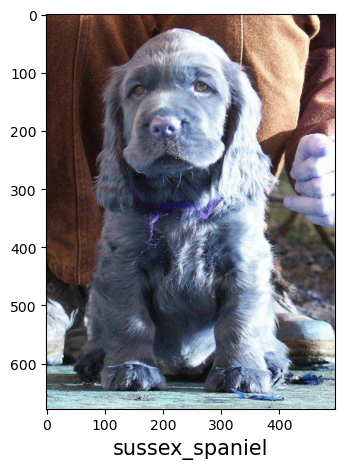

In [61]:
plt.figure(figsize=(6,6))

for index , data in test_dataframe[:10].iterrows():
    img = data['file_name']
    label = data['breed']
    img = cv2.imread(img)
#     plt.subplot(2,5, index+1)
    plt.imshow(img)
    plt.xlabel(label,fontsize = (15))
    plt.tight_layout()
    plt.show()    

In [62]:
submission=pd.DataFrame(y_pred,columns=classes_to_num.keys())
submission

affenpinscher  afghan_hound  african_hunting_dog      airedale  \
0       1.577751e-06  2.211804e-06         2.423086e-06  3.672055e-06   
1       7.927225e-08  2.302259e-08         8.573271e-08  4.361759e-08   
2       4.246501e-05  4.398027e-04         3.788911e-04  1.225374e-04   
3       1.922626e-08  2.482811e-11         6.912121e-12  7.088858e-12   
4       1.052728e-02  3.177127e-05         2.452237e-05  1.117600e-05   
...              ...           ...                  ...           ...   
10352   9.594268e-05  7.250302e-05         2.504950e-04  1.675102e-04   
10353   1.190806e-05  5.681469e-06         3.736549e-06  1.060501e-05   
10354   2.197399e-06  1.408249e-06         1.787453e-04  1.834571e-06   
10355   9.685208e-05  9.280055e-05         3.230406e-05  8.727829e-05   
10356   2.334240e-06  9.416737e-06         4.231479e-06  2.287890e-06   

       american_staffordshire_terrier   appenzeller  australian_terrier  \
0                        1.295079e-06  2.261996e-06        2.259735e-06   
1                        3.193312e-08  1.607524e-08        1.544117e-08   
2                        8.006192e-05  1.003245e-04        1.417191e-04   
3                        4.875231e-11  2.086556e-12        3.801841e-11   
4                        2.125825e-05  1.047040e-04        4.643451e-05   
...                               ...           ...                 ...   
10352                    6.459348e-05  1.009866e-04        1.079023e-04   
10353                    9.936231e-06  2.404639e-06        6.933883e-06   
10354                    1.790051e-06  7.475289e-07        1.291773e-06   
10355                    9.247032e-05  6.009611e-05        2.533876e-04   
10356                    6.107478e-06  2.281571e-06        2.055196e-06   

            basenji        basset        beagle  ...    toy_poodle  \
0      1.779375e-06  3.252100e-06  2.686976e-06  ...  1.902862e-06   
1      7.735486e-08  6.733229e-08  4.875156e-08  ...  4.495747e-08   
2      1.155285e-04  9.349133e-05  1.303463e-04  ...  7.934279e-05   
3      4.271408e-09  1.043796e-10  1.893133e-11  ...  1.043132e-12   
4      3.328255e-05  1.084380e-04  3.420357e-05  ...  8.727631e-06   
...             ...           ...           ...  ...           ...   
10352  2.332236e-04  8.002318e-05  7.314487e-05  ...  3.826389e-04   
10353  3.836429e-06  3.266612e-06  4.100702e-06  ...  1.234087e-06   
10354  1.606599e-06  1.378639e-05  3.320667e-06  ...  1.072456e-06   
10355  6.869320e-05  7.343613e-05  4.262643e-05  ...  5.518367e-04   
10356  4.429424e-06  2.329293e-06  1.947519e-06  ...  2.207108e-06   

        toy_terrier        vizsla  walker_hound    weimaraner  \
0      2.246543e-06  3.197656e-06  2.981371e-06  3.102025e-06   
1      4.042811e-08  5.073646e-08  6.142157e-08  5.065765e-08   
2      1.266864e-04  2.264851e-04  1.224448e-04  2.071410e-04   
3      1.336950e-10  1.809528e-10  1.796503e-11  2.799878e-10   
4      3.233040e-05  2.221458e-05  4.895153e-05  1.770033e-05   
...             ...           ...           ...           ...   
10352  1.619933e-04  1.983859e-04  2.462693e-04  7.820061e-05   
10353  2.503553e-06  2.107264e-04  3.712541e-06  9.984435e-01   
10354  2.435558e-06  1.004637e-06  4.053002e-06  1.373807e-06   
10355  2.903645e-05  1.479345e-04  9.145831e-05  1.997647e-05   
10356  7.876628e-06  3.890715e-06  1.805506e-05  1.223553e-05   

       welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0                2.908205e-06                 3.093502e-06  1.634498e-06   
1                3.558654e-08                 9.124897e-07  7.770429e-08   
2                8.773858e-05                 1.031352e-04  1.521228e-04   
3                2.787610e-11                 1.121717e-11  1.696633e-09   
4                1.674006e-05                 3.115391e-05  1.326773e-05   
...                       ...                          ...           ...   
10352            1.294939e-04                 7.570058e-05  4.312061e-04   

In [63]:
pd.set_option('display.float_format', lambda x: '%.15f' % x)
submission

affenpinscher      afghan_hound  african_hunting_dog  \
0     0.000001577750595 0.000002211804485    0.000002423086016   
1     0.000000079272247 0.000000023022592    0.000000085732708   
2     0.000042465006118 0.000439802737674    0.000378891127184   
3     0.000000019226258 0.000000000024828    0.000000000006912   
4     0.010527282953262 0.000031771269278    0.000024522365493   
...                 ...               ...                  ...   
10352 0.000095942683402 0.000072503018600    0.000250495038927   
10353 0.000011908057786 0.000005681468792    0.000003736548706   
10354 0.000002197398999 0.000001408249091    0.000178745263838   
10355 0.000096852076240 0.000092800553830    0.000032304058550   
10356 0.000002334240435 0.000009416737157    0.000004231478670   

               airedale  american_staffordshire_terrier       appenzeller  \
0     0.000003672054845               0.000001295078732 0.000002261996087   
1     0.000000043617593               0.000000031933116 0.000000016075241   
2     0.000122537443531               0.000080061916378 0.000100324512459   
3     0.000000000007089               0.000000000048752 0.000000000002087   
4     0.000011175997315               0.000021258250854 0.000104703955003   
...                 ...                             ...               ...   
10352 0.000167510152096               0.000064593477873 0.000100986624602   
10353 0.000010605011994               0.000009936231436 0.000002404639417   
10354 0.000001834570753               0.000001790050646 0.000000747528929   
10355 0.000087278291176               0.000092470319942 0.000060096113884   
10356 0.000002287889856               0.000006107477930 0.000002281570914   

       australian_terrier           basenji            basset  \
0       0.000002259734629 0.000001779375111 0.000003252100441   
1       0.000000015441168 0.000000077354862 0.000000067332294   
2       0.000141719123349 0.000115528542665 0.000093491325970   
3       0.000000000038018 0.000000004271408 0.000000000104380   
4       0.000046434506658 0.000033282547520 0.000108438027382   
...                   ...               ...               ...   
10352   0.000107902335003 0.000233223559917 0.000080023179180   
10353   0.000006933883014 0.000003836429187 0.000003266612339   
10354   0.000001291773174 0.000001606598516 0.000013786392628   
10355   0.000253387639532 0.000068693203502 0.000073436131061   
10356   0.000002055195637 0.000004429424280 0.000002329292784   

                 beagle  ...        toy_poodle       toy_terrier  \
0     0.000002686976131  ... 0.000001902861754 0.000002246543318   
1     0.000000048751563  ... 0.000000044957471 0.000000040428109   
2     0.000130346292281  ... 0.000079342789832 0.000126686427393   
3     0.000000000018931  ... 0.000000000001043 0.000000000133695   
4     0.000034203574614  ... 0.000008727631212 0.000032330401154   
...                 ...  ...               ...               ...   
10352 0.000073144874477  ... 0.000382638914743 0.000161993259098   
10353 0.000004100701517  ... 0.000001234086994 0.000002503552651   
10354 0.000003320667474  ... 0.000001072455689 0.000002435557917   
10355 0.000042626434151  ... 0.000551836739760 0.000029036453270   
10356 0.000001947518740  ... 0.000002207107855 0.000007876627933   

                 vizsla      walker_hound        weimaraner  \
0     0.000003197656497 0.000002981370926 0.000003102024721   
1     0.000000050736457 0.000000061421574 0.000000050657651   
2     0.000226485091844 0.000122444806038 0.000207141041756   
3     0.000000000180953 0.000000000017965 0.000000000279988   
4     0.000022214575438 0.000048951529607 0.000017700331227   
...                 ...               ...               ...   
10352 0.000198385940166 0.000246269279160 0.000078200610005   
10353 0.000210726415389 0.000003712540774 0.998443543910980   
10354 0.000001004637056 0.000004053002158 0.000001373807436   
10355 0.000147934508277 0.000091458314273 0.000019976474505   
1

In [64]:
sample_df

id     affenpinscher      afghan_hound  \
0      000621fb3cbb32d8935728e48679680e 0.008333333333333 0.008333333333333   
1      00102ee9d8eb90812350685311fe5890 0.008333333333333 0.008333333333333   
2      0012a730dfa437f5f3613fb75efcd4ce 0.008333333333333 0.008333333333333   
3      001510bc8570bbeee98c8d80c8a95ec1 0.008333333333333 0.008333333333333   
4      001a5f3114548acdefa3d4da05474c2e 0.008333333333333 0.008333333333333   
...                                 ...               ...               ...   
10352  ffeda8623d4eee33c6d1156a2ecbfcf8 0.008333333333333 0.008333333333333   
10353  fff1ec9e6e413275984966f745a313b0 0.008333333333333 0.008333333333333   
10354  fff74b59b758bbbf13a5793182a9bbe4 0.008333333333333 0.008333333333333   
10355  fff7d50d848e8014ac1e9172dc6762a3 0.008333333333333 0.008333333333333   
10356  fffbff22c1f51e3dc80c4bf04089545b 0.008333333333333 0.008333333333333   

       african_hunting_dog          airedale  american_staffordshire_terrier  \
0        0.008333333333333 0.008333333333333               0.008333333333333   
1        0.008333333333333 0.008333333333333               0.008333333333333   
2        0.008333333333333 0.008333333333333               0.008333333333333   
3        0.008333333333333 0.008333333333333               0.008333333333333   
4        0.008333333333333 0.008333333333333               0.008333333333333   
...                    ...               ...                             ...   
10352    0.008333333333333 0.008333333333333               0.008333333333333   
10353    0.008333333333333 0.008333333333333               0.008333333333333   
10354    0.008333333333333 0.008333333333333               0.008333333333333   
10355    0.008333333333333 0.008333333333333               0.008333333333333   
10356    0.008333333333333 0.008333333333333               0.008333333333333   

            appenzeller  australian_terrier           basenji  \
0     0.008333333333333   0.008333333333333 0.008333333333333   
1     0.008333333333333   0.008333333333333 0.008333333333333   
2     0.008333333333333   0.008333333333333 0.008333333333333   
3     0.008333333333333   0.008333333333333 0.008333333333333   
4     0.008333333333333   0.008333333333333 0.008333333333333   
...                 ...                 ...               ...   
10352 0.008333333333333   0.008333333333333 0.008333333333333   
10353 0.008333333333333   0.008333333333333 0.008333333333333   
10354 0.008333333333333   0.008333333333333 0.008333333333333   
10355 0.008333333333333   0.008333333333333 0.008333333333333   
10356 0.008333333333333   0.008333333333333 0.008333333333333   

                 basset  ...        toy_poodle       toy_terrier  \
0     0.008333333333333  ... 0.008333333333333 0.008333333333333   
1     0.008333333333333  ... 0.008333333333333 0.008333333333333   
2     0.008333333333333  ... 0.008333333333333 0.008333333333333   
3     0.008333333333333  ... 0.008333333333333 0.008333333333333   
4     0.008333333333333  ... 0.008333333333333 0.008333333333333   
...                 ...  ...               ...               ...   
10352 0.008333333333333  ... 0.008333333333333 0.008333333333333   
10353 0.008333333333333  ... 0.008333333333333 0.008333333333333   
10354 0.008333333333333  ... 0.008333333333333 0.008333333333333   
10355 0.008333333333333  ... 0.008333333333333 0.008333333333333   
10356 0.008333333333333  ... 0.008333333333333 0.008333333333333   

                 vizsla      walker_hound        weimaraner  \
0     0.008333333333333 0.008333333333333 0.008333333333333   
1     0.008333333333333 0.008333333333333 0.008333333333333   
2     0.008333333333333 0.008333333333333 0.008333333333333   
3     0.008333333333333 0.008333333333333 0.008333333333333   
4     0.008333333333333 0.008333333333333 0.008333333333333   
...                 ...               ...               ...   
10352 0.008333333333333 0.008333333333333 0.008333333333333   
10353 0.008333333333333 0

In [65]:
sample_df=sample_df[['id']]
sample_df

id
0      000621fb3cbb32d8935728e48679680e
1      00102ee9d8eb90812350685311fe5890
2      0012a730dfa437f5f3613fb75efcd4ce
3      001510bc8570bbeee98c8d80c8a95ec1
4      001a5f3114548acdefa3d4da05474c2e
...                                 ...
10352  ffeda8623d4eee33c6d1156a2ecbfcf8
10353  fff1ec9e6e413275984966f745a313b0
10354  fff74b59b758bbbf13a5793182a9bbe4
10355  fff7d50d848e8014ac1e9172dc6762a3
10356  fffbff22c1f51e3dc80c4bf04089545b

[10357 rows x 1 columns]

In [66]:
submission=pd.merge(sample_df,submission,left_index=True,right_index=True)
submission

id     affenpinscher      afghan_hound  \
0      000621fb3cbb32d8935728e48679680e 0.000001577750595 0.000002211804485   
1      00102ee9d8eb90812350685311fe5890 0.000000079272247 0.000000023022592   
2      0012a730dfa437f5f3613fb75efcd4ce 0.000042465006118 0.000439802737674   
3      001510bc8570bbeee98c8d80c8a95ec1 0.000000019226258 0.000000000024828   
4      001a5f3114548acdefa3d4da05474c2e 0.010527282953262 0.000031771269278   
...                                 ...               ...               ...   
10352  ffeda8623d4eee33c6d1156a2ecbfcf8 0.000095942683402 0.000072503018600   
10353  fff1ec9e6e413275984966f745a313b0 0.000011908057786 0.000005681468792   
10354  fff74b59b758bbbf13a5793182a9bbe4 0.000002197398999 0.000001408249091   
10355  fff7d50d848e8014ac1e9172dc6762a3 0.000096852076240 0.000092800553830   
10356  fffbff22c1f51e3dc80c4bf04089545b 0.000002334240435 0.000009416737157   

       african_hunting_dog          airedale  american_staffordshire_terrier  \
0        0.000002423086016 0.000003672054845               0.000001295078732   
1        0.000000085732708 0.000000043617593               0.000000031933116   
2        0.000378891127184 0.000122537443531               0.000080061916378   
3        0.000000000006912 0.000000000007089               0.000000000048752   
4        0.000024522365493 0.000011175997315               0.000021258250854   
...                    ...               ...                             ...   
10352    0.000250495038927 0.000167510152096               0.000064593477873   
10353    0.000003736548706 0.000010605011994               0.000009936231436   
10354    0.000178745263838 0.000001834570753               0.000001790050646   
10355    0.000032304058550 0.000087278291176               0.000092470319942   
10356    0.000004231478670 0.000002287889856               0.000006107477930   

            appenzeller  australian_terrier           basenji  \
0     0.000002261996087   0.000002259734629 0.000001779375111   
1     0.000000016075241   0.000000015441168 0.000000077354862   
2     0.000100324512459   0.000141719123349 0.000115528542665   
3     0.000000000002087   0.000000000038018 0.000000004271408   
4     0.000104703955003   0.000046434506658 0.000033282547520   
...                 ...                 ...               ...   
10352 0.000100986624602   0.000107902335003 0.000233223559917   
10353 0.000002404639417   0.000006933883014 0.000003836429187   
10354 0.000000747528929   0.000001291773174 0.000001606598516   
10355 0.000060096113884   0.000253387639532 0.000068693203502   
10356 0.000002281570914   0.000002055195637 0.000004429424280   

                 basset  ...        toy_poodle       toy_terrier  \
0     0.000003252100441  ... 0.000001902861754 0.000002246543318   
1     0.000000067332294  ... 0.000000044957471 0.000000040428109   
2     0.000093491325970  ... 0.000079342789832 0.000126686427393   
3     0.000000000104380  ... 0.000000000001043 0.000000000133695   
4     0.000108438027382  ... 0.000008727631212 0.000032330401154   
...                 ...  ...               ...               ...   
10352 0.000080023179180  ... 0.000382638914743 0.000161993259098   
10353 0.000003266612339  ... 0.000001234086994 0.000002503552651   
10354 0.000013786392628  ... 0.000001072455689 0.000002435557917   
10355 0.000073436131061  ... 0.000551836739760 0.000029036453270   
10356 0.000002329292784  ... 0.000002207107855 0.000007876627933   

                 vizsla      walker_hound        weimaraner  \
0     0.000003197656497 0.000002981370926 0.000003102024721   
1     0.000000050736457 0.000000061421574 0.000000050657651   
2     0.000226485091844 0.000122444806038 0.000207141041756   
3     0.000000000180953 0.000000000017965 0.000000000279988   
4     0.000022214575438 0.000048951529607 0.000017700331227   
...                 ...               ...               ...   
10352 0.000198385940166 0.000246269279160 0.000078200610005   
10353 0.000210726415389 0

In [67]:
submission.to_csv('dog_breed_classifier2.csv',index=None)

In [70]:
pd.read_csv('dog_breed_classifier2.csv')

id     affenpinscher      afghan_hound  \
0      000621fb3cbb32d8935728e48679680e 0.000001577750600 0.000002211804500   
1      00102ee9d8eb90812350685311fe5890 0.000000079272250 0.000000023022592   
2      0012a730dfa437f5f3613fb75efcd4ce 0.000042465006000 0.000439802740000   
3      001510bc8570bbeee98c8d80c8a95ec1 0.000000019226258 0.000000000024828   
4      001a5f3114548acdefa3d4da05474c2e 0.010527283000000 0.000031771270000   
...                                 ...               ...               ...   
10352  ffeda8623d4eee33c6d1156a2ecbfcf8 0.000095942680000 0.000072503020000   
10353  fff1ec9e6e413275984966f745a313b0 0.000011908058000 0.000005681469000   
10354  fff74b59b758bbbf13a5793182a9bbe4 0.000002197399000 0.000001408249100   
10355  fff7d50d848e8014ac1e9172dc6762a3 0.000096852076000 0.000092800554000   
10356  fffbff22c1f51e3dc80c4bf04089545b 0.000002334240400 0.000009416737000   

       african_hunting_dog          airedale  american_staffordshire_terrier  \
0        0.000002423086000 0.000003672054800               0.000001295078700   
1        0.000000085732710 0.000000043617593               0.000000031933116   
2        0.000378891130000 0.000122537440000               0.000080061920000   
3        0.000000000006912 0.000000000007089               0.000000000048752   
4        0.000024522365000 0.000011175997000               0.000021258250000   
...                    ...               ...                             ...   
10352    0.000250495040000 0.000167510150000               0.000064593480000   
10353    0.000003736548700 0.000010605012000               0.000009936231000   
10354    0.000178745260000 0.000001834570800               0.000001790050600   
10355    0.000032304060000 0.000087278290000               0.000092470320000   
10356    0.000004231478700 0.000002287889900               0.000006107478000   

            appenzeller  australian_terrier           basenji  \
0     0.000002261996000   0.000002259734600 0.000001779375100   
1     0.000000016075240   0.000000015441168 0.000000077354860   
2     0.000100324510000   0.000141719120000 0.000115528540000   
3     0.000000000002087   0.000000000038018 0.000000004271408   
4     0.000104703955000   0.000046434507000 0.000033282548000   
...                 ...                 ...               ...   
10352 0.000100986625000   0.000107902335000 0.000233223560000   
10353 0.000002404639400   0.000006933883000 0.000003836429000   
10354 0.000000747528930   0.000001291773200 0.000001606598500   
10355 0.000060096114000   0.000253387640000 0.000068693200000   
10356 0.000002281571000   0.000002055195600 0.000004429424300   

                 basset  ...        toy_poodle       toy_terrier  \
0     0.000003252100400  ... 0.000001902861800 0.000002246543300   
1     0.000000067332294  ... 0.000000044957470 0.000000040428110   
2     0.000093491326000  ... 0.000079342790000 0.000126686430000   
3     0.000000000104380  ... 0.000000000001043 0.000000000133695   
4     0.000108438030000  ... 0.000008727631000 0.000032330400000   
...                 ...  ...               ...               ...   
10352 0.000080023180000  ... 0.000382638910000 0.000161993260000   
10353 0.000003266612300  ... 0.000001234087000 0.000002503552700   
10354 0.000013786393000  ... 0.000001072455700 0.000002435558000   
10355 0.000073436130000  ... 0.000551836740000 0.000029036453000   
10356 0.000002329292800  ... 0.000002207107900 0.000007876628000   

                 vizsla      walker_hound        weimaraner  \
0     0.000003197656500 0.000002981371000 0.000003102024700   
1     0.000000050736457 0.000000061421574 0.000000050657650   
2     0.000226485090000 0.000122444800000 0.000207141040000   
3     0.000000000180953 0.000000000017965 0.000000000279988   
4     0.000022214575000 0.000048951530000 0.000017700331000   
...                 ...               ...               ...   
10352 0.000198385940000 0.000246269280000 0.000078200610000   
10353 0.000210726420000 0

# Conclusion 

In [ ]:
I had classified each test data image into nine different dog breeds.
For the classification of various dog breeds, I had made a deep learning model and the model got maximum accuracy of around 
92.37% with only five epochs.